# Exploring Delahaye mQTLs: Replication, Cleaning, and Enrichment
Goals:
1. Load in data and assess replication between Placental Regulation (Delahaye) dataset, RICHS, and Placental data from the Robinson Lab
1. Assess effect of genotype dosage on number of significant mQTLs, repeating for sex-stratified dosage filters
1. Assess hits that stand-up to "fine mapping"
1. Assess effect sizes of sex-specific hits in terms of differences in allelic fold-change (aFC)
1. Categorize hits based on their position relative to 
    1. Chromosome
    1. CpG islands

In [1]:
import dask.dataframe as dd
import dask.array as da
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob

%load_ext rpy2.ipython
%R library(tidyverse)
%R library(ggpubr)
%R library(GGally)
%R library(data.table)
%R library(ggsci)
%Rdevice png

Matplotlib created a temporary config/cache directory at /tmp/pbs.2407665.pbsha.ib.sockeye/matplotlib-183pjguk because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.3
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

R[write to console]: data.table 1.12.2 using 16 threads (see ?getD

## Replication assessment
### Loading in marginal data 
This is slightly faster in python, I have saved large datasets as a parquet file, which can be read using `pandas` and `pyarrow` in python, and the `arrow` library in R.

In [2]:
%%time
delahaye = dd.read_parquet("../../delahaye_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all.parquet")

CPU times: user 19.6 ms, sys: 11.2 ms, total: 30.8 ms
Wall time: 53 ms


Just checking that enrichment is what I would expect for cis-mQTL analysis (mostly uniform other than many hits due to enrichment of signal in *cis*).

CPU times: user 3min, sys: 30.3 s, total: 3min 30s
Wall time: 2min 39s


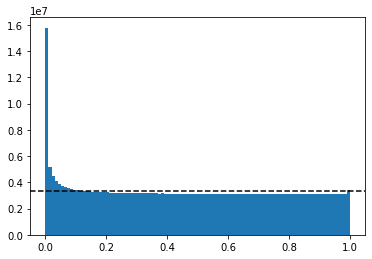

In [3]:
%%time
hist, bins = da.histogram(delahaye['p-value'],bins=100, range=[0,1])
hist = hist.compute()
x = 0.5 * (bins[1:] + bins[:-1])
width = np.diff(bins)
plt.bar(x, hist, width);
plt.axhline(y=hist.sum() / 100.0, linestyle='--', color='black')

Loading in remaining data:

In [3]:
richs = dd.read_parquet("../../RICHS_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all.parquet")
robinson = dd.read_parquet("../../robinson_results/cis_impute_mQTL_results_6_methy_PC.parquet")

### Replication of marginal signals

In [4]:
%%time
def run_replication(df1,df2):
    return df2.merge(df1, on=['SNP','gene'])

# Make data frame of hits and then filter for parallel merge
richs_hits = richs[richs['p-value'] < (0.05 / len(richs))].compute()
robinson_hits =robinson[robinson['FDR'] < (0.05 / len(robinson))].compute()
delahaye_hits = delahaye[delahaye['FDR'] < (0.05 / len(delahaye))].compute()

# Retrieve hits pvalues in df2 corresponding to hits in df1
delahaye_richs = run_replication(delahaye_hits, richs)
richs_delahaye = run_replication(richs_hits, delahaye)
delahaye_robinson = run_replication(delahaye_hits, robinson)
robinson_delahaye = run_replication(robinson_hits,delahaye)

CPU times: user 7min 57s, sys: 1min 8s, total: 9min 5s
Wall time: 7min 22s


In [5]:
delahaye_richs_p = delahaye_richs['p-value_x'].compute()
richs_delahaye_p = richs_delahaye['p-value_x'].compute()
delahaye_robinson_p = delahaye_robinson['p-value_x'].compute()
robinson_delahaye_p = robinson_delahaye['p-value_x'].compute()

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [6]:
%%R -i delahaye_richs_p,richs_delahaye_p,delahaye_robinson_p,robinson_delahaye_p
library(qvalue)
print(1 - pi0est(na.omit(delahaye_richs_p))$pi0)
print(1 - pi0est(na.omit(richs_delahaye_p))$pi0)
print(1 - pi0est(na.omit(delahaye_robinson_p))$pi0)
print(1 - pi0est(na.omit(robinson_delahaye_p))$pi0)

[1] 0.9576195
[1] 0.9433685
[1] 0.9844906
[1] 0.9965438


### Loading in sex-specific signals

In [3]:
delahaye_sex = dd.read_parquet("../../delahaye_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all_sex_interaction.parquet")
richs_sex = dd.read_parquet("../../RICHS_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all_sex_interaction.parquet")
robinson_sex = dd.read_parquet("../../robinson_results/cis_int_sex_impute_mQTL_results_6_methy_PC.parquet")

The number of overlapping hits is fairly small so the $\pi_1$ metric will not be very useful. Instead I'll just assess overlap in hits:

In [28]:
%%time 
# Make data frame of hits and then filter for parallel merge
richs_hits_sex = richs_sex[richs_sex['FDR'] < 0.05].compute()
robinson_hits_sex =robinson_sex[robinson_sex['FDR'] < 0.05].compute()
delahaye_hits_sex = delahaye_sex[delahaye_sex['FDR'] < 0.05].compute()

delahaye_richs_sex = run_replication(delahaye_hits_sex, richs_sex).compute()
richs_delahaye_sex = run_replication(richs_hits_sex, delahaye_sex).compute()
delahaye_robinson_sex = run_replication(delahaye_hits_sex, robinson_sex).compute()
robinson_delahaye_sex = run_replication(robinson_hits_sex, delahaye_sex).compute()

print(len(delahaye_richs_sex))
print(len(richs_delahaye_sex))
print(len(delahaye_robinson_sex))
print(len(robinson_delahaye_sex))

80363
53204
12922
21225
CPU times: user 13min 58s, sys: 2min 14s, total: 16min 12s
Wall time: 9min 59s


The number of CpG sites with at least one sb-mQTL:

In [31]:
print(len(delahaye_richs_sex['gene'].unique()))
print(len(richs_delahaye_sex['gene'].unique()))
print(len(delahaye_robinson_sex['gene'].unique()))
print(len(robinson_delahaye_sex['gene'].unique()))

20874
11275
3204
3998


## Effect of genotype dosage on number of mQTLs in Delahaye data
### Marginal
#### Loading in required data
**Required data:**
* Minor allele frequencies (`.afreq` file)
* Marginal hits (computed on dask dataframe)


In [4]:
delahaye_maf = pd.read_csv("../../delahaye_QC/placenta_regulatory_landscape/RootStudyConsentSet_phs001717.PlacentalRegulation.v1.p1.c1.HMB-IRB-PUB-COL-MDS/genotype_qc/all_imputed_r2_30_rsid.afreq",sep='\s+')
if not "delahaye_hits" in vars():
    delahaye_hits = delahaye[delahaye['FDR'] < 0.05].compute()


/home/wcasazza/miniconda3/envs/big_data/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Filtering
By default `plink` filters minor allele frequency (MAF) at one end. I.e. if I filter using the command
```bash
plink --bfile data\
    --maf 0.01\
    --make-bed\
    --out data_filtered
```
the resulting files will still contain SNPs with MAF > 0.99. I didn't account for this when running `matrixEQTL` to run associations so I'm going to account for it now, and test MAF thresholds at 0.05 as well.

In [51]:
# Get SNPs at specified threshold
maf01 = delahaye_maf[(delahaye_maf['ALT_FREQS'] >= 0.01) & (delahaye_maf['ALT_FREQS'] <= 0.99)]['ID']
maf05 = delahaye_maf[(delahaye_maf['ALT_FREQS'] >= 0.05) & (delahaye_maf['ALT_FREQS'] <= 0.95)]['ID']

# Filter hits
print(f"Delahaye hits: {len(delahaye_hits)}")
print(f"Delahaye hits at true MAF > 0.01 : {len(delahaye_hits[delahaye_hits['SNP'].isin(maf01)])}")
print(f"Delahaye hits at true MAF > 0.05 : {len(delahaye_hits[delahaye_hits['SNP'].isin(maf05)])}")
# Unique
print(f"CpGs with one hit in Delahaye: {len(delahaye_hits['gene'].unique())}")
print(f"CpGs with one hit in Delahaye at true MAF > 0.01 : {len(delahaye_hits[delahaye_hits['SNP'].isin(maf01)]['gene'].unique())}")
print(f"CpGs with one hit in Delahaye at true MAF > 0.05 : {len(delahaye_hits[delahaye_hits['SNP'].isin(maf05)]['gene'].unique())}")

Delahaye hits: 8712448
Delahaye hits at true MAF > 0.01 : 7649972
Delahaye hits at true MAF > 0.05 : 6498652
CpGs with one hit in Delahaye: 275806
CpGs with one hit in Delahaye at true MAF > 0.01 : 203617
CpGs with one hit in Delahaye at true MAF > 0.05 : 164780


### Sex-specific
#### Loading in required data
**Required data:**
* Genotypes for sex-specific hits (for sex specific minor allele frequencies)
* Sex labels
* Sex specific hits (computed on dask dataframe)

In [6]:
if not "delahaye_hits_sex" in vars():
    delahaye_hits_sex = delahaye_sex[delahaye_sex['FDR'] < 0.05].compute()

# Filter SNPs to those in hits
genotypes = dd.read_csv("../../delahaye_QC/matrix_eqtl_data/all_imputed_matrixeQTL.txt", sep='\s+')
genotypes = genotypes[genotypes['SNP'].isin(delahaye_hits_sex['SNP'])].compute()

# Read in metadata
metadata = pd.read_csv("../../delahaye_QC/matrix_eqtl_data/mQTL_covar_9_methy_PC.txt", sep='\s+')

#### Filtering
The filters to try here are:
1. Global MAF filters of 0.01, 0.05 (tested on marginal hits in previous section)
1. Dosage filters requireing 0.01, 0.05 subjects in each dosage group
1. Sex specific MAF and dosage filters

In [53]:
def maf_filter(geno, N, maf): # SNP, genotypes, subjects
    freq = ((geno.iloc[:,1:].sum(axis=1)) / (2*N)).to_numpy()
    print(min(freq))
    return geno['SNP'][(freq >= maf) & (freq <= (1.0 - maf))]

def dosage_filter(dosage_freq, N, maf):
    filt1 = (dosage_freq / N) >= maf
    filt2 = (dosage_freq / N )<= (1.0 - maf)
    ix1 = filt1.apply(np.all,axis=1).to_numpy().flatten()
    ix2 = filt2.apply(np.all,axis=1).to_numpy().flatten()
    return dosage_freq.index[ix1 & ix2]

male_ix = metadata[metadata['id'] == "Sex"].iloc[:,1:] == 1
female_ix = metadata[metadata['id'] == "Sex"].iloc[:,1:] == 0
males = ['SNP'] + metadata.columns[1:][male_ix.to_numpy().flatten()].tolist()
females = ['SNP'] + metadata.columns[1:][female_ix.to_numpy().flatten()].tolist()


all_01 = maf_filter(genotypes, len(genotypes.columns) - 1, 0.01)
all_05 = maf_filter(genotypes, len(genotypes.columns) - 1, 0.05)
male_01 = maf_filter(genotypes[males], len(males) - 1, 0.01)
male_05 = maf_filter(genotypes[males], len(males) - 1, 0.05)
female_01 = maf_filter(genotypes[females], len(females) - 1, 0.01)
female_05 = maf_filter(genotypes[females], len(females) - 1, 0.05)


# Dosage specific filtering
enum = genotypes.round().melt('SNP')
male_enum = genotypes[males].round().melt('SNP')
female_enum = genotypes[females].round().melt('SNP')

dosage = pd.crosstab(enum['SNP'], enum['value'])
male_dosage = pd.crosstab(male_enum['SNP'], male_enum['value'])
female_dosage = pd.crosstab(female_enum['SNP'], female_enum['value'])

all_dosage_01 = dosage_filter(dosage, len(genotypes.columns) - 1, 0.01)
all_dosage_05 = dosage_filter(dosage, len(genotypes.columns) - 1, 0.05)
male_dosage_01 = dosage_filter(male_dosage, len(males) - 1, 0.01)
male_dosage_05 = dosage_filter(male_dosage, len(males) - 1, 0.05)
female_dosage_01 = dosage_filter(female_dosage, len(females) - 1, 0.01)
female_dosage_05 = dosage_filter(female_dosage, len(females) - 1, 0.05)

# Print a nice table
result = pd.DataFrame(
    { 
        'group': ['all', 'males', 'females','all', 'males', 'females'],
        'MAF' : [0.01,0.01,0.01,0.05,0.05,0.05],
        'True MAF': [len(all_01), len(male_01), len(female_01),len(all_05),len(male_05),len(female_05)],
        'dosage': [len(all_dosage_01), len(male_dosage_01), len(female_dosage_01),len(all_dosage_05),len(male_dosage_05),len(female_dosage_05)]
    }
)
result

0.0030527272727272634
0.0030527272727272634
0.0014194630872483229
0.0014194630872483229
0.0009880952380952387
0.0009880952380952387


,group,MAF,True MAF,dosage
0,all,0.01,94588,19977
1,males,0.01,92973,16249
2,females,0.01,101851,16976
3,all,0.05,25439,6264
4,males,0.05,24454,4758
5,females,0.05,28117,5712


In [9]:
print(male_dosage[male_dosage.index.isin(all_dosage_05)].head())

value             0.0  1.0  2.0
SNP                            
10:14754625:A:G     5   79   65
10:463600:T:G      49   81   19
11:2932535:G:C      8   48   93
11:8913156:T:G     14   53   82
13:111959610:G:A   76   60   13


## Fine mapping mQTLs with CAVIAR
In a separate analysis I'm doing, I used the model [CAVIAR](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4196608/) to assess those SNPs regressed against each CpG site have a non-zero "causal posterior probability" (CPP) as fine-mapped blood eQTLs had some nice properties when their enrichment in different diseases was assessed using LD score regression.

Here I'm going to break down how these SNPs compare to the MAF and dosage filters above.

### Marginal mQTL CAVIAR annotation
The annotation I have that's nicely mapped to positions is currently just in autosomes. I will load the X chromosome separately.

In [18]:
marginal_caviar = dd.read_csv("../../1000G_phase3_ldsc/single_delahaye_annotations/marginal_maxCPP.*.annot.gz", sep="\s+").compute()
marginal_caviar.head()
marginal_caviar[marginal_caviar['maxCPP'] != 0.0].head()

/home/wcasazza/miniconda3/envs/big_data/lib/python3.8/site-packages/dask/dataframe/io/csv.py:471: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  warn(


,CHR,BP,SNP,CM,maxCPP
938,1,831027,rs372366328,0.620827,1.883030e-09
953,1,833421,rs115244455,0.620827,5.852460e-10
969,1,834991,rs116090519,0.620827,3.879490e-13
990,1,838830,rs77144359,0.620827,1.212150e-01
1013,1,842825,rs7519340,0.620827,2.822830e-17


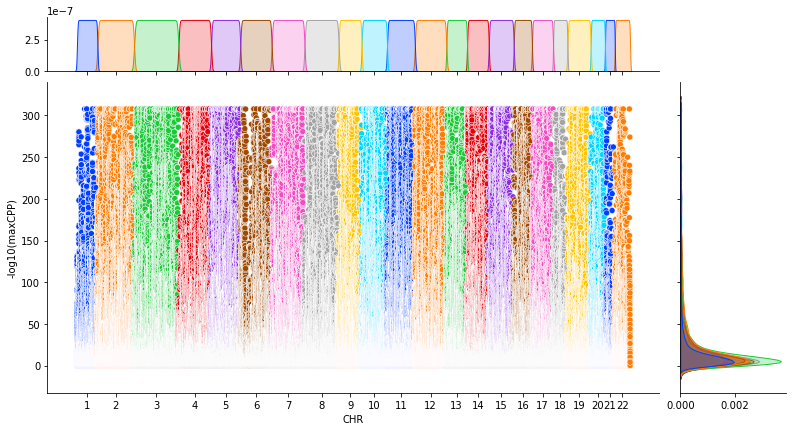

In [57]:
import seaborn as sns
to_plot = marginal_caviar[marginal_caviar['maxCPP'] != 0.0]
to_plot = to_plot.sort_values(['CHR','BP']).reset_index()
to_plot['neg_log_maxCPP'] = -1 * np.log10(to_plot['maxCPP'])
to_plot['i'] = to_plot.index
plot = sns.jointplot(
    data = to_plot,
    x = 'i', 
    y='neg_log_maxCPP',
    hue="CHR", 
    palette = "bright",
    marginal_ticks = True,
    legend = None)
chrom_df=to_plot.groupby('CHR')['i'].median()
plot.ax_joint.set_xlabel('CHR')
plot.ax_joint.set_ylabel("-log10(maxCPP)")
plot.ax_joint.set(xticks = chrom_df, xticklabels=chrom_df.index)
plot.fig.set_figwidth(12)

So it seems many non-zero causal probabilities being small (the majority are centered around $10^{-20}$ or so) and that their range is pretty huge. 

Let's load in all chromosomes and enumerate some hits:

In [7]:
import glob 
from multiprocessing import Pool
def read_path(path):
    df = pd.read_csv(path,sep='\s+')
    df['path'] = path
    return df

paths = glob.glob("../../delahaye_QC/caviar_files/marginal/**/*.out_post")
pool = Pool(32)
dfs = pool.map(read_path, paths)
pool.close()
pool.join()
marginal_caviar_all = pd.concat(dfs)
marginal_caviar_all = marginal_caviar_all[marginal_caviar_all['Causal_Post._Prob.'] != 0.0]
marginal_caviar_all["probe"] = marginal_caviar_all['path'].str.extract(r'.*/(.*).out_post')
marginal_caviar_all["CHR"] = marginal_caviar_all['path'].str.extract(r'.*/chr(.*)/.*out_post')
marginal_caviar_all = marginal_caviar_all.drop('path',axis=1)
marginal_caviar_all

,SNP_ID,Prob_in_pCausalSet,Causal_Post._Prob.,probe,CHR
0,rs186003573,1.266040e-06,2.532070e-06,cg14950855,12
1,rs78795824,7.223250e-07,1.444650e-06,cg14950855,12
2,rs7980178,7.070980e-07,1.414190e-06,cg14950855,12
3,rs147426699,5.690030e-08,1.138000e-07,cg14950855,12
4,rs564596866,5.690030e-08,1.138000e-07,cg14950855,12
...,...,...,...,...,...
106,rs9650491,9.574470e-13,1.914890e-12,cg17826006,8
107,rs34380789,5.749780e-10,1.149960e-09,cg17826006,8
108,rs4875935,5.747850e-10,1.149570e-09,cg17826006,8
109,rs112180998,9.543520e-13,1.908700e-12,cg17826006,8


In [8]:
print(f"Non-zero CPP {len(marginal_caviar_all)}\nUnique CpGs:{len(marginal_caviar_all['probe'].unique())}")

Non-zero CPP 7775879
Unique CpGs:99522


<AxesSubplot:xlabel='CHR'>

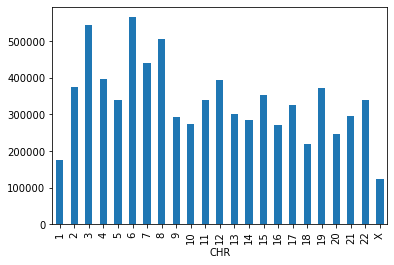

In [44]:
chr_ord = [str(i) for i in range(1,23)] + ["X"]
marginal_caviar_all.groupby("CHR").count().sort_values('CHR').reindex(chr_ord)['SNP_ID'].plot(kind='bar')

<AxesSubplot:xlabel='CHR'>

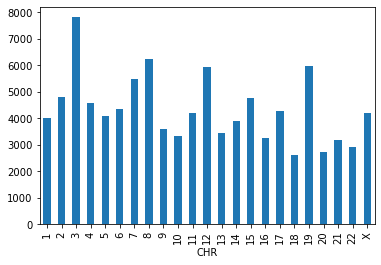

In [45]:
marginal_caviar_all.drop_duplicates(subset=['probe']).groupby("CHR").count().sort_values('CHR').reindex(chr_ord)['SNP_ID'].plot(kind='bar')

### Sex biased mQTL CAVIAR annotation

In [ ]:
def read_path(path):
    df = pd.read_csv(path,sep='\s+')
    df['path'] = path
    return df

paths = glob.glob("../../delahaye_QC/caviar_files/sex_interaction/**/*.out_post")
pool = Pool(32)
dfs = pool.map(read_path, paths)
pool.close()
pool.join()
sex_caviar_all = pd.concat(dfs)
sex_caviar_all = sex_caviar_all[sex_caviar_all['Causal_Post._Prob.'] != 0.0]
sex_caviar_all["probe"] = sex_caviar_all['path'].str.extract(r'.*/(.*).out_post')
sex_caviar_all["CHR"] = sex_caviar_all['path'].str.extract(r'.*/chr(.*)/.*out_post')
sex_caviar_all = sex_caviar_all.drop('path',axis=1)
sex_caviar_all

In [25]:
print(f"Non-zero CPP {len(sex_caviar_all)}\nUnique CpGs:{len(sex_caviar_all['probe'].unique())}")

Non-zero CPP 3465338
Unique CpGs:97554


<AxesSubplot:xlabel='CHR'>

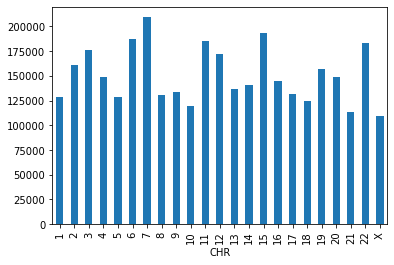

In [35]:
chr_ord = [str(i) for i in range(1,23)] + ["X"]
sex_caviar_all.groupby("CHR").count().reindex(chr_ord)['SNP_ID'].plot(kind='bar')

<AxesSubplot:xlabel='CHR'>

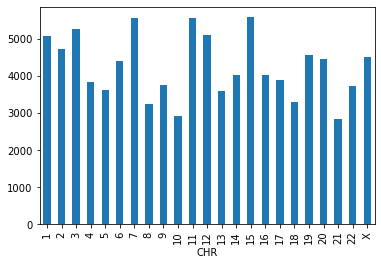

In [36]:
sex_caviar_all.drop_duplicates(subset=['probe']).groupby("CHR").count().sort_values('CHR').reindex(chr_ord)['SNP_ID'].plot(kind='bar')

## Allelic fold change differences in Males vs Females

For sex-specfic hits (at an interaction FDR < 0.05), I've further gone on to compute allelic fold change [(aFC) citation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5668944/). In the Robinson data, I've observed that females have a higher mean aFC. Here I'm going to assess the extent to which that's true in the Delahaye dataset.

1.0
1.0


<AxesSubplot:>

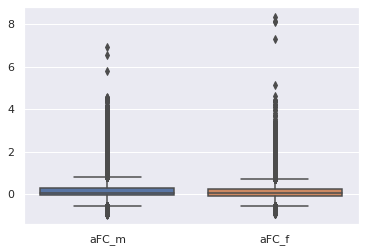

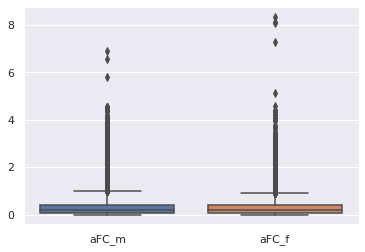

In [11]:
import seaborn as sns
from scipy import stats
sns.set()
snp_df = pd.read_csv("../../delahaye_QC/matrix_eqtl_data/snp_pos.txt",sep='\s+')
aFC_df = pd.read_csv("../../delahaye_QC/delahaye_stratified_regression_fdr_hits.txt", sep='\s+')
dosage_filter = all_05
aFC_df = aFC_df[aFC_df['SNP'].isin(dosage_filter)]
_, p_value = stats.ttest_ind(aFC_df.aFC_m, aFC_df.aFC_f,alternative='less',equal_var=False)
print(p_value)
sns.boxplot(data=aFC_df[['aFC_m', 'aFC_f']])
_, p_value_abs = stats.ttest_ind(abs(aFC_df.aFC_m), abs(aFC_df.aFC_f),alternative='less',equal_var=False)
print(p_value_abs)
plt.figure()

sns.boxplot(data=abs(aFC_df[['aFC_m', 'aFC_f']]))


	Wilcoxon rank sum test with continuity correction

data:  abs(aFC_df$aFC_m) and abs(aFC_df$aFC_f)
W = 8429751, p-value < 2.2e-16
alternative hypothesis: true location shift is less than 0


	Wilcoxon rank sum test with continuity correction

data:  aFC_df$aFC_m and aFC_df$aFC_f
W = 9494519, p-value = 4.74e-09
alternative hypothesis: true location shift is less than 0



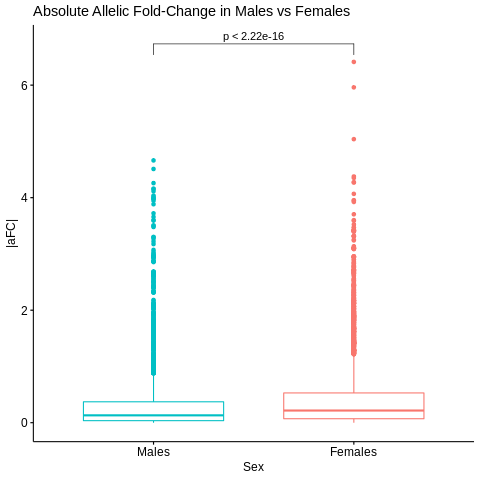

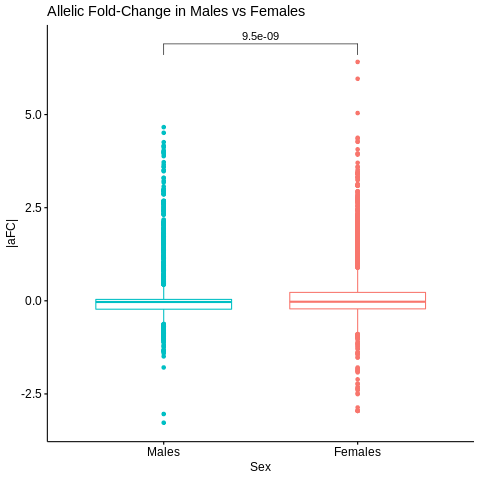

In [9]:
%%R -i aFC_df
print(wilcox.test(abs(aFC_df$aFC_m),abs(aFC_df$aFC_f),alternative="less"))
to_plot <- rbind(data.frame(aFC=abs(aFC_df$aFC_m), Sex = "Males"),data.frame(aFC=abs(aFC_df$aFC_f), Sex = "Females"))
p1 <- ggboxplot(to_plot, x = "Sex", y = "aFC",color="Sex") +
    stat_compare_means(comparisons=list(c("Females","Males"))) +
    labs(y = "|aFC|") +
    guides(color=FALSE)+
    ggtitle("Absolute Allelic Fold-Change in Males vs Females") +
    scale_colour_manual(values=c("#00bfc4","#f8766d"))
print(p1)   
print(wilcox.test(aFC_df$aFC_m,aFC_df$aFC_f,alternative="less"))
to_plot <- rbind(data.frame(aFC=aFC_df$aFC_m, Sex = "Males"),data.frame(aFC=aFC_df$aFC_f, Sex = "Females"))
p2 <- ggboxplot(to_plot, x = "Sex", y = "aFC",color="Sex") +
    stat_compare_means(comparisons=list(c("Females","Males"))) +
    labs(y = "|aFC|") +
    guides(color=FALSE)+
    ggtitle("Allelic Fold-Change in Males vs Females") +
    scale_colour_manual(values=c("#00bfc4","#f8766d"))
print(p2)

Removing the X chromosome:

In [12]:
aFC_df_filt = aFC_df[aFC_df['SNP'].isin(snp_df[snp_df['CHR'] != "chrX"]['SNP'])]


	Wilcoxon rank sum test with continuity correction

data:  abs(aFC_df$aFC_m) and abs(aFC_df$aFC_f)
W = 315869153, p-value = 2.566e-06
alternative hypothesis: true location shift is less than 0


	Wilcoxon rank sum test with continuity correction

data:  aFC_df$aFC_m and aFC_df$aFC_f
W = 325430273, p-value = 0.8878
alternative hypothesis: true location shift is less than 0



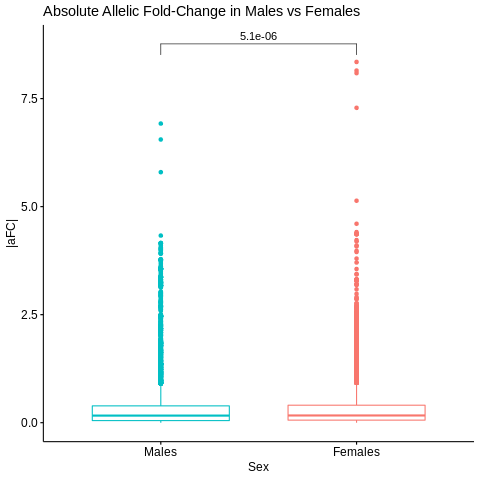

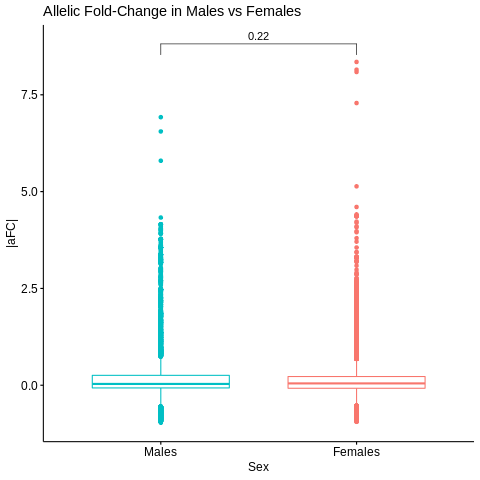

In [13]:
%%R -i aFC_df_filt
aFC_df <- aFC_df_filt
print(wilcox.test(abs(aFC_df$aFC_m),abs(aFC_df$aFC_f),alternative="less"))
to_plot <- rbind(data.frame(aFC=abs(aFC_df$aFC_m), Sex = "Males"),data.frame(aFC=abs(aFC_df$aFC_f), Sex = "Females"))
p1 <- ggboxplot(to_plot, x = "Sex", y = "aFC",color="Sex") +
    stat_compare_means(comparisons=list(c("Females","Males"))) +
    labs(y = "|aFC|") +
    guides(color=FALSE)+
    ggtitle("Absolute Allelic Fold-Change in Males vs Females") +
    scale_colour_manual(values=c("#00bfc4","#f8766d"))
print(p1)   
print(wilcox.test(aFC_df$aFC_m,aFC_df$aFC_f,alternative="less"))
to_plot <- rbind(data.frame(aFC=aFC_df$aFC_m, Sex = "Males"),data.frame(aFC=aFC_df$aFC_f, Sex = "Females"))
p2 <- ggboxplot(to_plot, x = "Sex", y = "aFC",color="Sex") +
    stat_compare_means(comparisons=list(c("Females","Males"))) +
    labs(y = "|aFC|") +
    guides(color=FALSE)+
    ggtitle("Allelic Fold-Change in Males vs Females") +
    scale_colour_manual(values=c("#00bfc4","#f8766d"))
print(p2)

## Differences in distribution of mQTLs vs male and female specific mQTLs
There are a few relevant factors here when I'm concerned less with getting a larger amount of SNPs and more with characterizing true "hits". In my tests looking at disease enrichment, my goal is to assess overlap between SNP-methylation associations, thus I do no thresholding on SNPs. What I've anecdotally observed is that the top hits for sex biased mQTLs present cleaner interactions between sex and genotype when restricted to those SNPs with enough samples containing each allele by sex. Thus when I'm characterizing sb-mQTLs based on position I'll be using this filter. 

### Difference in chromosome distribution of hits
I'm going to be using the same hits loaded in before, and threshold them as described above. I will call male vs female hits based on whether or not they meet that threshold in a stratified r robust regression.

I will also be loading in methylation data here and filtering out hits based on these criteria.

In [18]:
methylation = dd.read_csv("../../delahaye_QC/matrix_eqtl_data/methylation_matrixeQTL.txt", sep='\s+')
aFC_df_robust = pd.read_csv("../../delahaye_QC/delahaye_robust_regression_fdr_hits.txt", sep='\s+')
threshold = delahaye_hits_sex['p-value'].max()
dosage_filter = np.intersect1d(male_dosage_01,female_dosage_01)
dosage_filter_05 = np.intersect1d(male_dosage_05,female_dosage_05)
delahaye_sex_to_plot_chr = aFC_df[(aFC_df['p-value'] < threshold)]
delahaye_sex_to_plot_int = aFC_df_robust[((aFC_df_robust['res_f'] < threshold) | (aFC_df_robust['res_m'] < threshold)) & (aFC_df_robust['SNP'].isin(dosage_filter))]
sbmqtl_genotypes = genotypes[genotypes['SNP'].isin(delahaye_sex_to_plot_int['SNP'])]
sbmqtl_methylation = methylation[methylation['cpg'].isin(delahaye_sex_to_plot_int['gene'])].compute()

Below I'm going to count hits per chromosome per sex:

In [21]:
count_df = delahaye_sex_to_plot_chr.merge(
    snp_df,
    on="SNP"
).groupby("CHR").agg(
        Male = ("res_m", lambda x: -(x < threshold).sum()),
        Female = ("res_f", lambda x: (x < threshold).sum())
).reset_index().melt(id_vars="CHR", var_name="Sex", value_name="mQTLs")
len(dosage_filter)
sex_vec = metadata.set_index('id').transpose()['Sex']
sex_vec = ["Male" if x == 1 else "Female" for x in sex_vec ]
count_df

,CHR,Sex,mQTLs
0,chr1,Male,-1078.0
1,chr10,Male,-304.0
2,chr11,Male,-477.0
3,chr12,Male,-435.0
4,chr13,Male,-122.0
5,chr14,Male,-458.0
6,chr15,Male,-309.0
7,chr16,Male,-494.0
8,chr17,Male,-1016.0
9,chr18,Male,-50.0


Now on to R to create a horizontal split bar plot and to plot a few interactions:

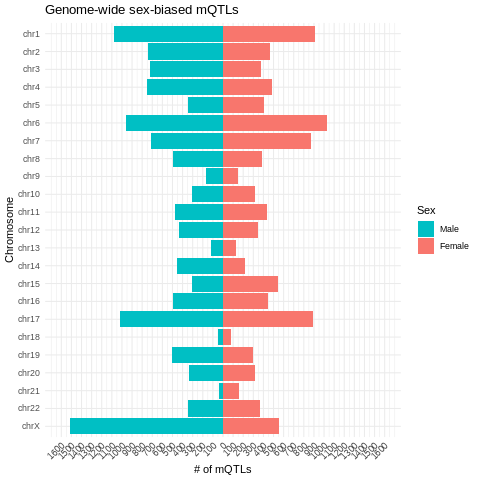

In [27]:
%%R -i count_df

count_df$CHR <- factor(count_df$CHR, levels = paste0("chr",c("X",22:1)))
count_df$Sex <- factor(count_df$Sex, levels = c("Male","Female"))
ggplot(count_df,aes(CHR,mQTLs,fill = Sex)) + 
    geom_bar(stat="identity",position="identity") +
    coord_flip() +
    scale_y_continuous(breaks=seq(-1600, 1600, 100),labels=as.character(c(seq(1600,0,-100),seq(100,1600,100))),limits=c(-1600,1600))+
    theme_minimal() +
    scale_fill_manual(values = c("#00bfc4","#f8766d"))+
    labs(y="# of mQTLs",x = "Chromosome") +
    ggtitle("Genome-wide sex-biased mQTLs") +
    theme(axis.text.x = element_text(angle=45,hjust=1,vjust=1))


Interaction plots for top 10 interactions:

             SNP       gene        beta    t-stat      p-value          FDR
61300  rs9912067 cg12550387  0.06625222  6.748347 1.000682e-10 5.482705e-07
63310 rs77598785 cg14405439  0.10407347  6.676609 1.519789e-10 8.062512e-07
66568  rs2741210 cg24804707  0.07474744  6.560672 2.967274e-10 1.497104e-06
76674  rs2649610 cg13169132  0.05844318  6.258261 1.637071e-09 7.171008e-06
86279 rs12674925 cg07765769 -0.12260389 -6.023655 5.926578e-09 2.307067e-05
86621 rs73121295 cg04031361  0.07866602  6.017270 6.134802e-09 2.378680e-05
             res_m       beta_m        se_m       aFC_m        res_f
61300 3.184014e-06 0.0096200756 0.003158647  0.26303238 7.212904e-05
63310 5.161114e-07 0.0128437091 0.003832908  0.34239173 4.595959e-03
66568 2.021690e-05 0.0141566516 0.003162753  0.06863254 1.982736e-05
76674 1.173183e-02 0.0142665071 0.002738763  0.03175256 1.101987e-05
86279 3.789101e-09 0.0003006541 0.006717836 -0.04137344 5.552186e-03
86621 9.272428e-03 0.0604707454 0.007979526  0.5230080

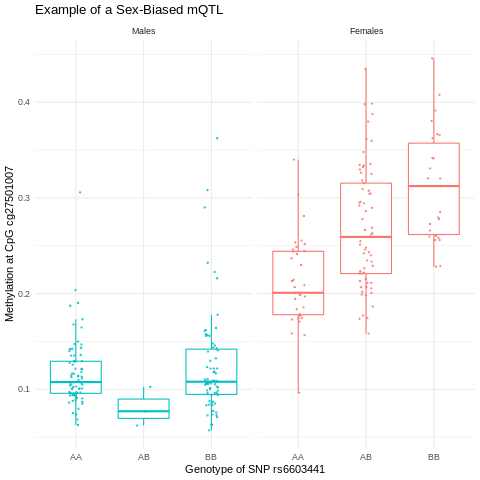

In [28]:
%%R -i sbmqtl_genotypes,sbmqtl_methylation,delahaye_sex_to_plot_int,sex_vec,threshold

delahaye_sex_to_plot_int <- delahaye_sex_to_plot_int%>% arrange(`p-value`,-abs(aFC_m - aFC_f)) %>% filter(!duplicated(gene),!duplicated(SNP))
print(head(delahaye_sex_to_plot_int))

for(i in c(9)){
    cur_cpg <- delahaye_sex_to_plot_int[i,]$gene
    cur_snp <- delahaye_sex_to_plot_int[i,]$SNP
    df <- data.frame(
        G = factor(round(as.numeric(sbmqtl_genotypes[sbmqtl_genotypes$SNP == cur_snp,-c(1)]))),
        M = as.numeric(sbmqtl_methylation[sbmqtl_methylation$cpg == cur_cpg,-c(1)]),
        Sex = unlist(sex_vec)
    )
    df$Sex <- factor(df$Sex, levels = c("Male","Female"), labels=c("Males","Females"))
    print(any(df$G == 0))
    p <- ggplot(df, aes(G,M, color= Sex)) +
        geom_boxplot(position="dodge",outlier.shape=NA) +
        geom_point(alpha= 0.7,size=0.5, position=position_jitterdodge()) +
        theme_minimal() +
        labs(x=sprintf("Genotype of SNP %s",cur_snp),y = sprintf("Methylation at CpG %s",cur_cpg)) +
        facet_grid(~Sex) +
        guides(color = FALSE)+
        scale_color_manual(values = c("#00bfc4","#f8766d"))+
        scale_x_discrete(labels=c("0"= "AA", "1" = "AB", "2"= "BB")) +
        ggtitle(sprintf("Example of a Sex-Biased mQTL",i))
    print(p)
}

### Differences in location relative to CpG islands
Now I'm going to load in an annotation and plot out differences in the location of mQTL CpG sites relative to CpG islands

In [66]:
methy_annotation = pd.read_csv("/scratch/st-dennisjk-1/wcasazza/450k_annotation.csv")
marginal_hits = delahaye_hits[delahaye_hits.SNP.isin(maf05)]
sex_annotated_df = aFC_df.merge(methy_annotation,left_on="gene",right_on="Name")
marginal_annotated_df = marginal_hits.merge(methy_annotation,left_on="gene",right_on="Name")
sex_annotated_df.head()

/home/wcasazza/miniconda3/envs/big_data/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,SNP,gene,beta,t-stat,p-value,FDR,res_m,beta_m,se_m,aFC_m,...,UCSC_RefGene_Name,UCSC_RefGene_Accession,UCSC_RefGene_Group,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
0,rs184002920,cg16206013,0.339823,12.898901,1.216774e-29,4.071669e-25,1.151063e-63,0.331070,0.010369,1.987265,...,APOO;APOO,NM_024122;NR_026545,Body;Body,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,rs189694925,cg16206013,0.339823,12.898901,1.216774e-29,4.071669e-25,1.151063e-63,0.331070,0.010369,1.987265,...,APOO;APOO,NM_024122;NR_026545,Body;Body,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,rs139772244,cg16206013,0.339823,12.898901,1.216774e-29,4.071669e-25,1.151063e-63,0.331070,0.010369,1.987265,...,APOO;APOO,NM_024122;NR_026545,Body;Body,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,rs73197315,cg16206013,0.331313,12.651779,8.437899e-29,2.640952e-24,8.202945e-62,0.319835,0.010393,1.873800,...,APOO;APOO,NM_024122;NR_026545,Body;Body,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,rs2707171,cg16206013,-0.119856,-5.712184,3.099018e-08,1.020947e-04,4.391719e-11,-0.109279,0.015195,-0.319853,...,APOO;APOO,NM_024122;NR_026545,Body;Body,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
male_annot = sex_annotated_df[sex_annotated_df['res_m'] < threshold][['gene','Relation_to_Island']].drop_duplicates(subset=['gene'])
male_annot['Sex'] = "Male"
female_annot = sex_annotated_df[sex_annotated_df['res_f'] < threshold][['gene','Relation_to_Island']].drop_duplicates(subset=['gene'])
female_annot['Sex'] = "Female"
marginal_annot = marginal_annotated_df[['gene','Relation_to_Island']].drop_duplicates(subset=['gene'])
marginal_annot['Sex'] = "Marginal"
sex_annot = sex_annotated_df[['gene','Relation_to_Island']].drop_duplicates(subset=['gene'])
sex_annot['Sex'] = "Sex-Biased"
sex_df_to_plot = pd.concat([male_annot,female_annot,marginal_annot,sex_annot])
sex_df_to_plot.to_csv("sex_df_hits_enum.csv",index=False)

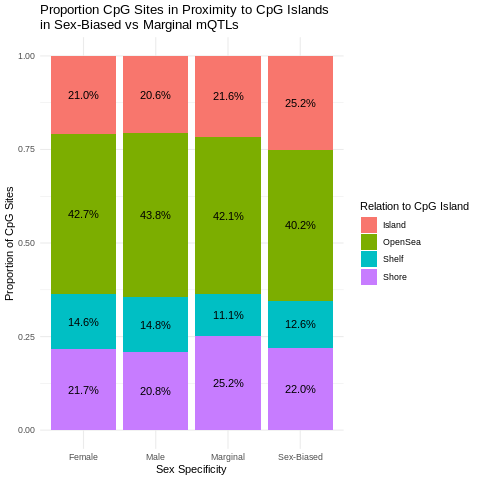

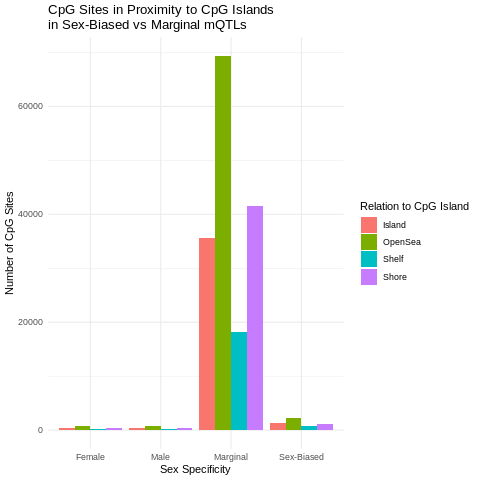

In [76]:
%%R -i sex_df_to_plot
sex_df_to_plot <- sex_df_to_plot %>% mutate(Relation_to_Island = gsub("N_|S_","",Relation_to_Island))
sex_df_to_plot$Relation_to_Island <- factor(sex_df_to_plot$Relation_to_Island)
sex_df_to_plot$Sex <- factor(sex_df_to_plot$Sex)

p <- ggplot(sex_df_to_plot, aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position = "fill") +
    theme_minimal() +
    geom_text(stat = "prop", position = position_fill(0.5)) +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Marginal mQTLs")
    print(p)

p <- ggplot(sex_df_to_plot, aes(Sex, fill = Relation_to_Island, by = Sex)) +
    geom_bar(position = "dodge") +
    theme_minimal() +
    labs(y = "Number of CpG Sites",x="Sex Specificity", fill = "Relation to CpG Island")+
    ggtitle("CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Marginal mQTLs")
    print(p)

### Checking whether or not CpG Sites are located within known imprinted genes
Gathered from [this publication](https://www-sciencedirect-com.ezproxy.library.ubc.ca/science/article/pii/S0092867419301060?via%3Dihub).

In [77]:
imprinted_genes = pd.read_csv("/scratch/st-dennisjk-1/wcasazza/imprinted_genes.tsv", sep='\t')
methy_annotation = methy_annotation.merge(imprinted_genes, left_on='UCSC_RefGene_Name', right_on="Gene")
sex_df_to_plot_new = sex_df_to_plot.merge(methy_annotation, right_on="Name", left_on="gene")
sex_df_to_plot_new.to_csv("sex_df_hits_enum_imprinted.csv",index=False)
sex_df_to_plot_new

,gene,Relation_to_Island_x,Sex,Unnamed: 0,chr,pos,strand,Name,AddressA,AddressB,...,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS,Gene,Locus,Expressed allele,Placenta
0,cg22213445,OpenSea,Male,cg22213445,chr3,128453826,+,cg22213445,28795337,NaN,...,NaN,True,NaN,NaN,NaN,NaN,RAB7A,NaN,NK,True
1,cg22213445,OpenSea,Marginal,cg22213445,chr3,128453826,+,cg22213445,28795337,NaN,...,NaN,True,NaN,NaN,NaN,NaN,RAB7A,NaN,NK,True
2,cg22213445,OpenSea,Sex-Biased,cg22213445,chr3,128453826,+,cg22213445,28795337,NaN,...,NaN,True,NaN,NaN,NaN,NaN,RAB7A,NaN,NK,True
3,cg25502086,Island,Male,cg25502086,chr10,71892093,-,cg25502086,32694401,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,AIFM2,NaN,P,True
4,cg25502086,Island,Female,cg25502086,chr10,71892093,-,cg25502086,32694401,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,AIFM2,NaN,P,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,cg12857785,OpenSea,Marginal,cg12857785,chr8,142205214,+,cg12857785,59617306,NaN,...,NaN,NaN,8:142274308-142274397,8:142204221-142205270,Gene_Associated_Cell_type_specific,NaN,DENND3,NaN,P,True
1012,ch.8.2842146R,OpenSea,Sex-Biased,ch.8.2842146R,chr8,142203859,+,ch.8.2842146R,38706465,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,DENND3,NaN,P,True
1013,cg16451872,S_Shore,Sex-Biased,cg16451872,chr15,25684818,-,cg16451872,49657402,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,UBE3A,SNURF-SNRPN,M,False
1014,cg07475000,OpenSea,Sex-Biased,cg07475000,chr7,22162928,-,cg07475000,35632399,63634347.0,...,NaN,NaN,NaN,NaN,NaN,NaN,RAPGEF5,NaN,P,True


In [78]:
new_to_plot = sex_df_to_plot_new[["gene","Sex", "Relation_to_Island_x","chr","strand","Expressed allele", "Placenta", "Gene"]]
new_to_plot.drop_duplicates(subset=['gene','Sex','Gene']).sort_values(['Sex'])

,gene,Sex,Relation_to_Island_x,chr,strand,Expressed allele,Placenta,Gene
19,cg22806076,Female,OpenSea,chr8,+,P,True,DLGAP2
25,cg13046440,Female,S_Shore,chr15,+,M,False,UBE3A
22,cg01226029,Female,Island,chr4,+,P,True,GPR78
16,cg13555519,Female,OpenSea,chr9,-,P,True,GLIS3
4,cg25502086,Female,Island,chr10,-,P,True,AIFM2
...,...,...,...,...,...,...,...,...
652,cg16202624,Sex-Biased,Island,chr6,+,P,True,AIM1
430,cg18061319,Sex-Biased,N_Shore,chr10,-,P,True,AIFM2
358,cg21657059,Sex-Biased,N_Shore,chr4,-,P,True,SFRP2
12,cg17611045,Sex-Biased,OpenSea,chr3,-,P,True,FGF12


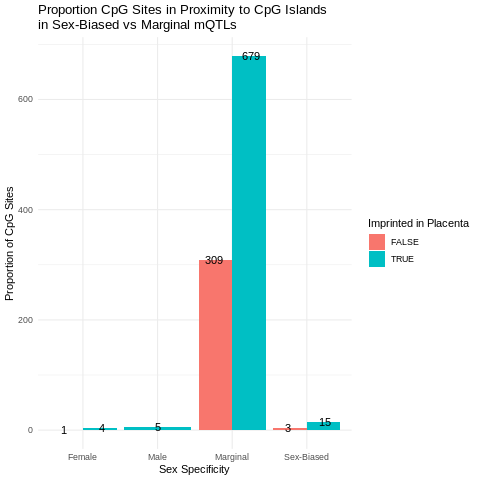

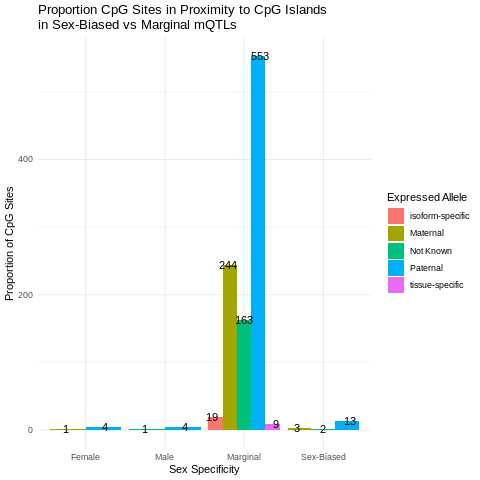

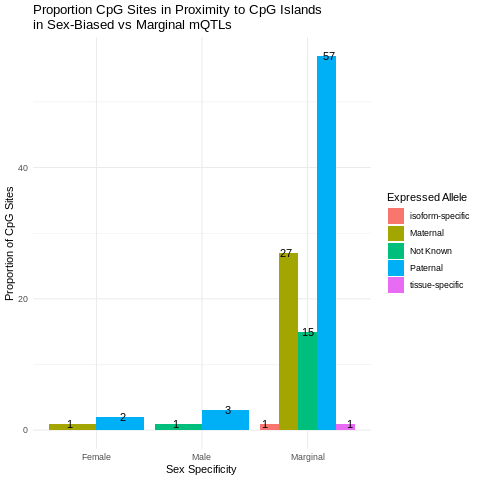

In [82]:
%%R -i new_to_plot


sex_df_to_plot <- new_to_plot %>% mutate(Relation_to_Island = gsub("N_|S_","",Relation_to_Island_x))
sex_df_to_plot$Relation_to_Island <- factor(sex_df_to_plot$Relation_to_Island)
sex_df_to_plot$Sex <- factor(sex_df_to_plot$Sex)
sex_df_to_plot <- sex_df_to_plot %>% mutate(`Expressed allele`=recode(`Expressed allele`,"M"="Maternal","P"="Paternal","NK"="Not Known"))
p <- ggplot(sex_df_to_plot, aes(Sex, fill = Placenta, by = Sex)) +
    geom_bar(position = "dodge") +
    theme_minimal() +
    geom_text(aes(label=..count..),stat = "count", position = position_dodge(1)) +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Imprinted in Placenta")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Marginal mQTLs")
    print(p)
    
p <- ggplot(sex_df_to_plot, aes(Sex, fill = `Expressed allele`, by = Sex)) +
    geom_bar(position = "dodge") +
    theme_minimal() +
    geom_text(aes(label=..count..),stat = "count", position = position_dodge(1)) +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Expressed Allele")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Marginal mQTLs")
    print(p)

p <- ggplot(sex_df_to_plot %>% filter(!duplicated(Gene,Sex)), aes(Sex, fill = `Expressed allele`, by = Sex)) +
    geom_bar(position = "dodge") +
    theme_minimal() +
    geom_text(aes(label=..count..),stat = "count", position = position_dodge(1)) +
    labs(y = "Proportion of CpG Sites",x="Sex Specificity", fill = "Expressed Allele")+
    ggtitle("Proportion CpG Sites in Proximity to CpG Islands\nin Sex-Biased vs Marginal mQTLs")
    print(p)

In [83]:
# Save data
sex_annotated_df.to_csv("../data/sex_annotated_hits.txt.gz",sep='\t',index = False)
marginal_annotated_df.to_csv("../data/marginal_annotated_hits.txt.gz",sep='\t',index = False)

## Additional quantitative summaries

### Some stratified LD score regression figures
First let's grab the number of SNPs available in each GWAS that match with my annotation:

In [41]:
def get_additional_data(f):
    #get total heritability, and SNPs kept for analysis
    with open(f,'r') as f:
        s = f.read()
    snps = re.search("\(([0-9]+) SNPs remain\)",s)
    basename = str(f).split('/')[-1]
    f_info = re.search("(sex_interaction|marginal|cord_mqtl)_(bin_CPP|maxCPP|all_cis)_(.*).log",basename)
    if f_info is None:
        print(f)
    if snps is None:
        snps = 0
        h2 = -1
        h2_se=-1
    else:
        snps = snps.group(1)
        h2_match = re.search("Total Observed scale h2: (.*) \((.+)\)",s)
        h2 = h2_match.group(1)
        h2_se = h2_match.group(2)
    return pd.DataFrame(
        {
            'GWAS': [f_info.group(3)],
            'annotation': [f_info.group(2)],
            'mQTL_group': [f_info.group(1)],
            'snps': [int(snps)],
            'h2': [float(h2)],
            'h2_se': [float(h2_se)]
        }
    )

logs = glob.glob("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_pgc_results/*.log")

ldsc_data = pd.concat([get_additional_data(f) for f in logs])
ldsc_data.to_csv("../data/ldsc_data.csv",index=False)

R[write to console]: Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3



                                                  GWAS         N
 1:       pgc_alcdep.afr_unrelated.aug2018_release.txt   4426.39
 2: pgc_alcdep.afr_unrel_genotyped.aug2018_release.txt   4587.06
 3:       pgc_alcdep.afr_discovery.aug2018_release.txt   4830.32
 4:                                        ocd_aug2017   9725.00
 5:                    NEW_META_PGC_iPSYCH_ASD_females  12838.00
 6:       meta_STDERR_mdd_eur_auto_M1_08_gcOFF_pgc.txt  12959.42
 7:                                         TS_Oct2018  14607.00
 8:                           anxiety.meta.full.cc.tbl  17310.00
 9: pgc_alcdep.eur_unrel_genotyped.aug2018_release.txt  17852.90
10:                           anxiety.meta.full.fs.tbl  18186.00
11: pgc_alcdep.trans_fe_unrel_geno.aug2018_release.txt  20293.60
12:                                   pgc_adhd_females  21191.00
13:                      NEW_META_PGC_iPSYCH_ASD_males  21752.00
14:       pgc_alcdep.eur_unrelated.aug2018_release.txt  21857.28
15:       meta_STDERR_mdd

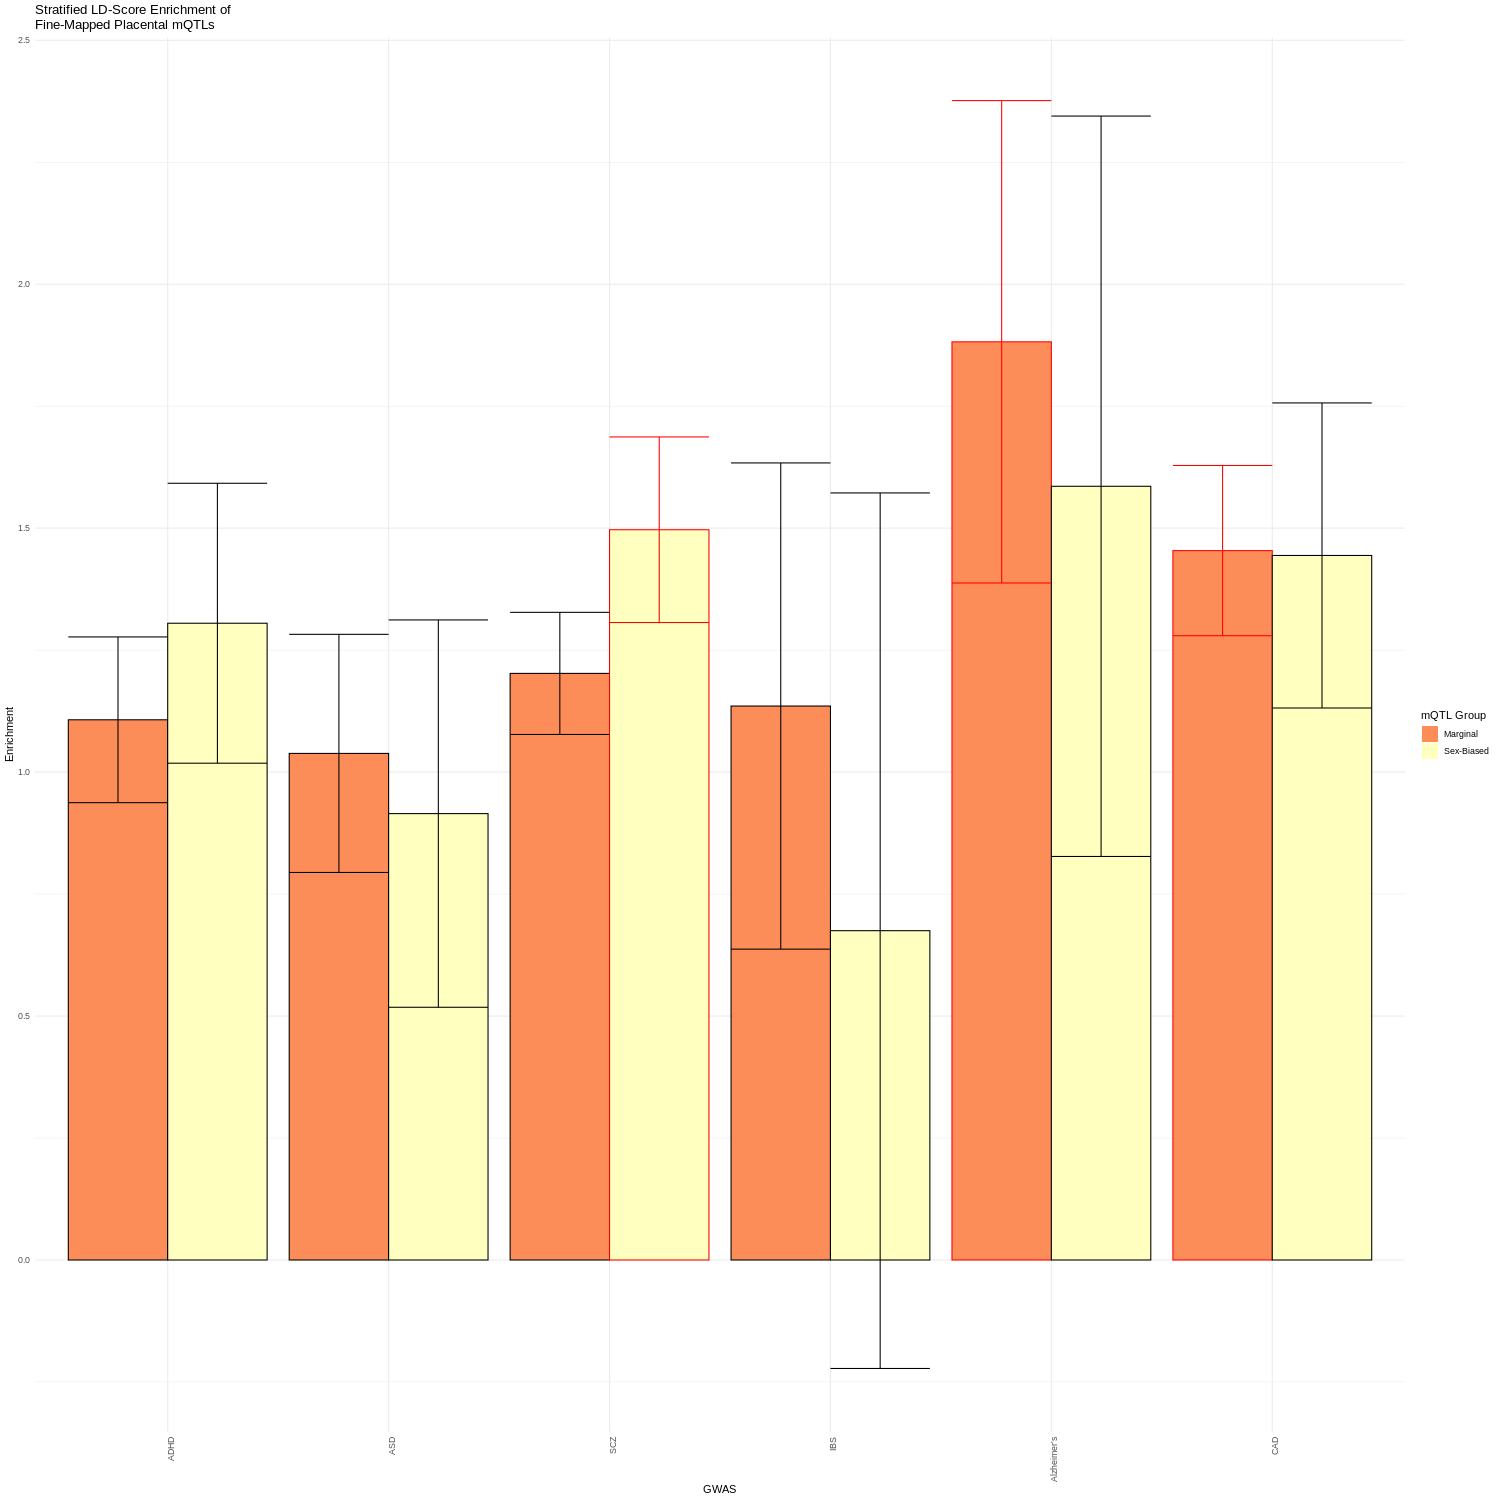

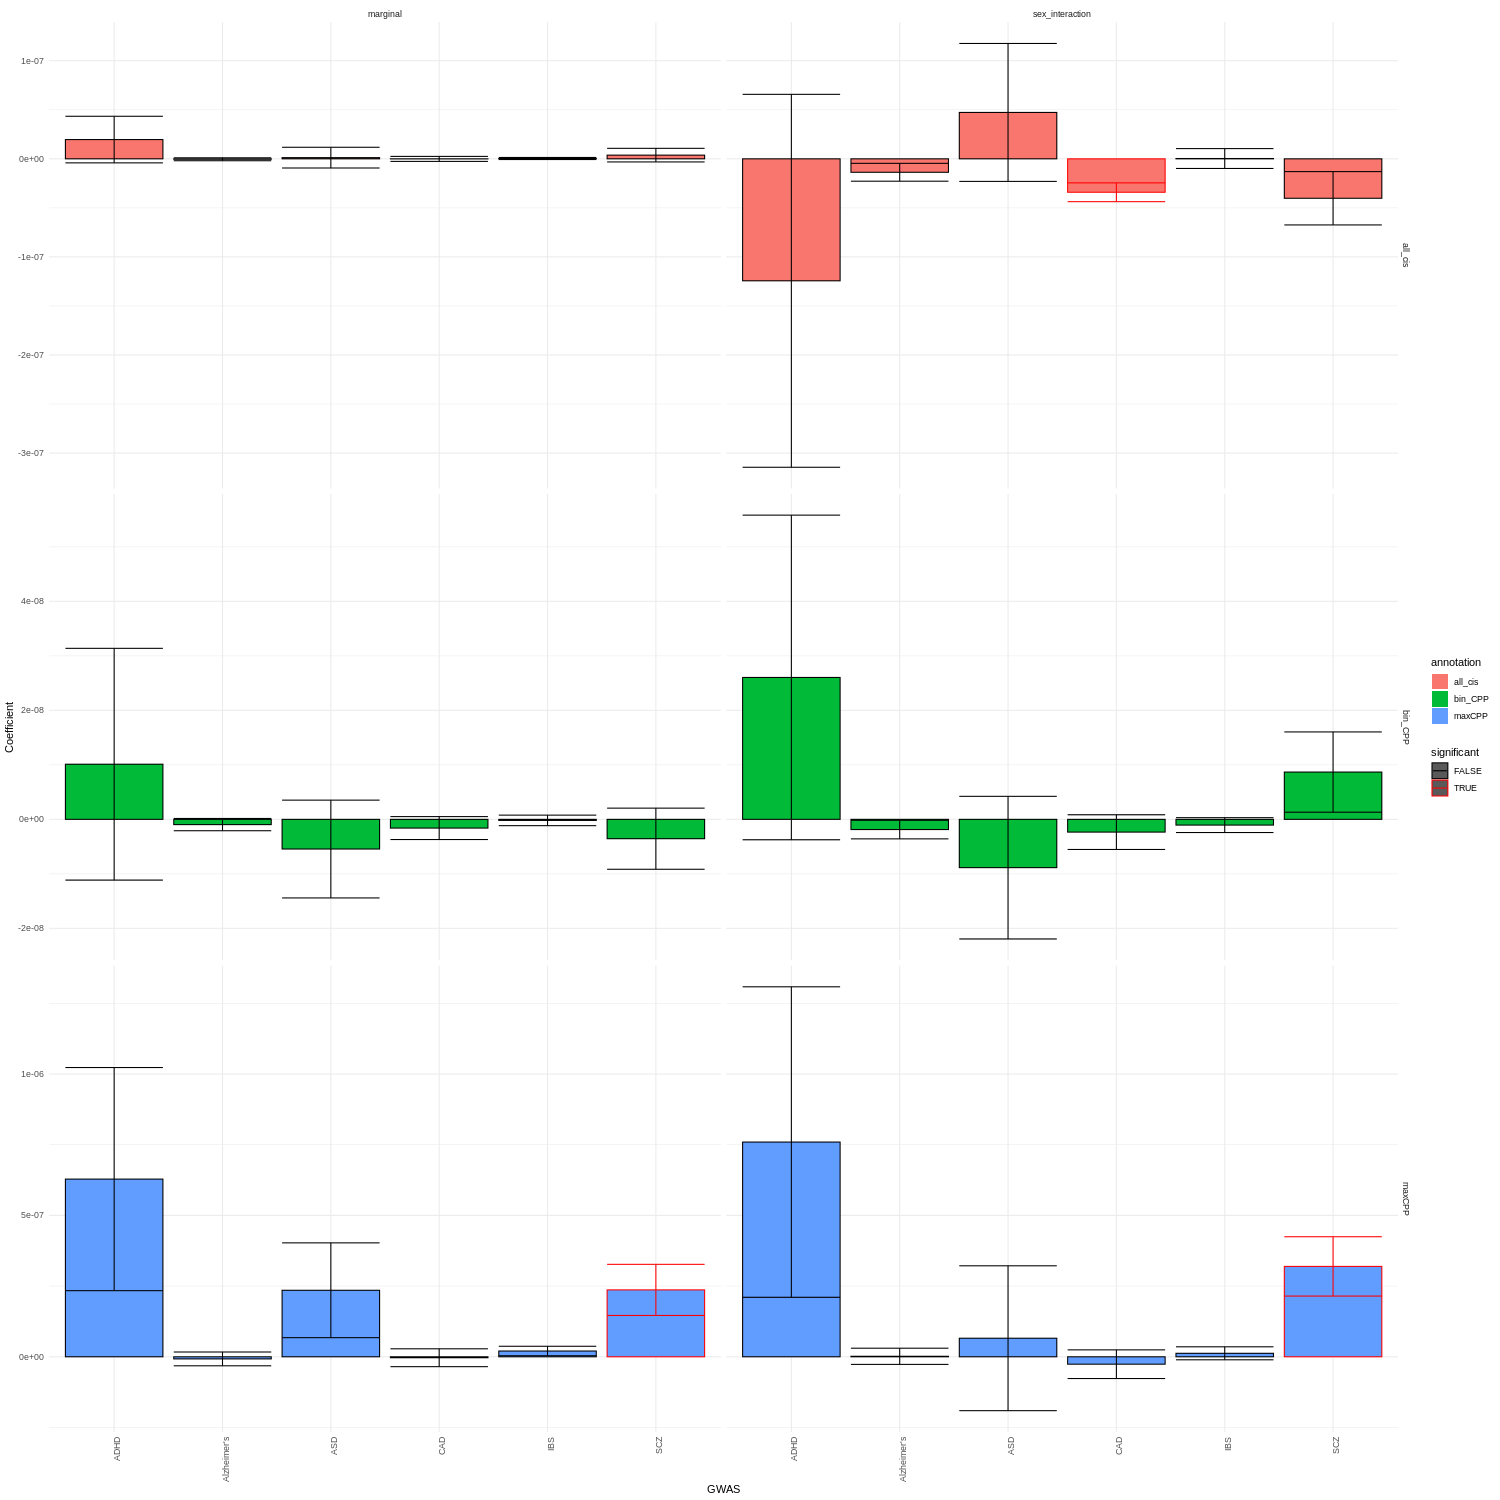

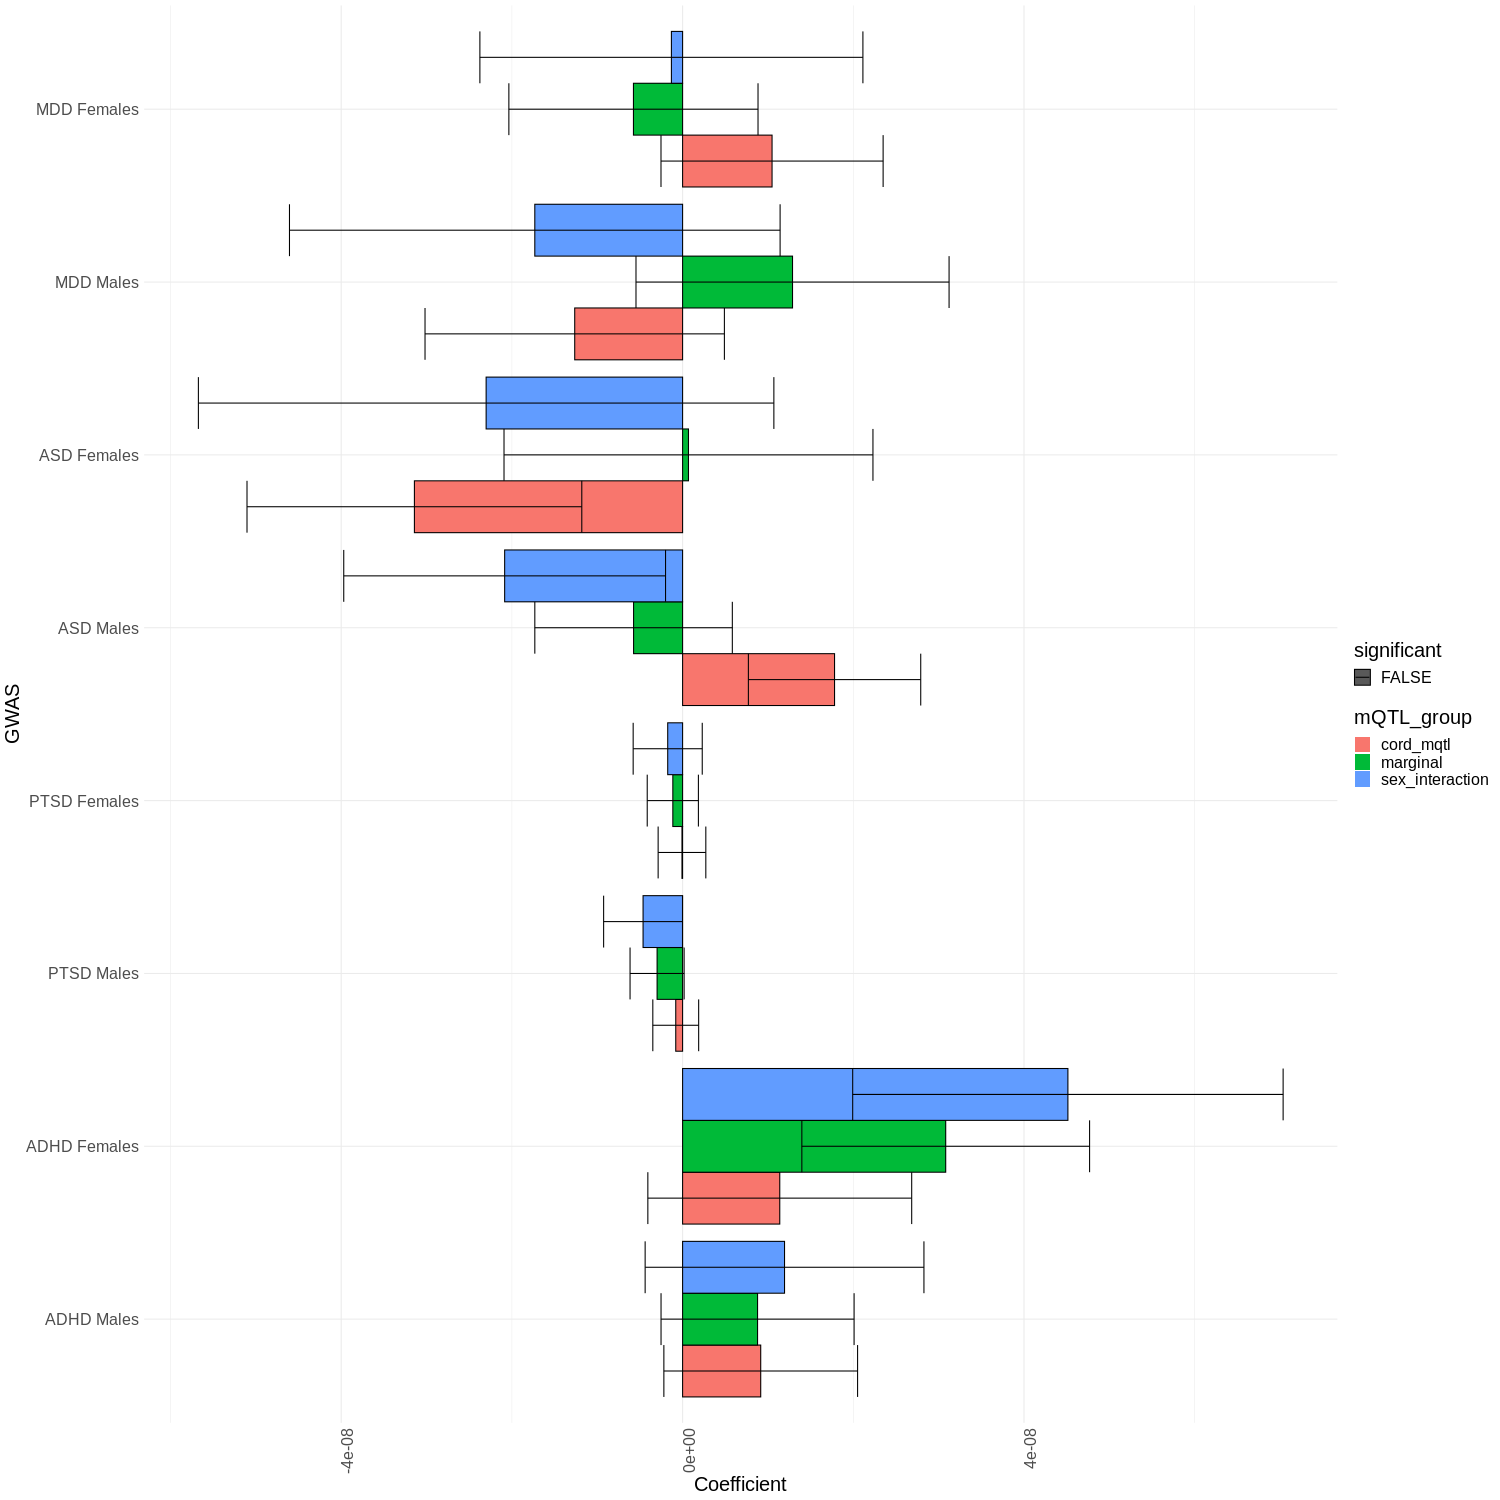

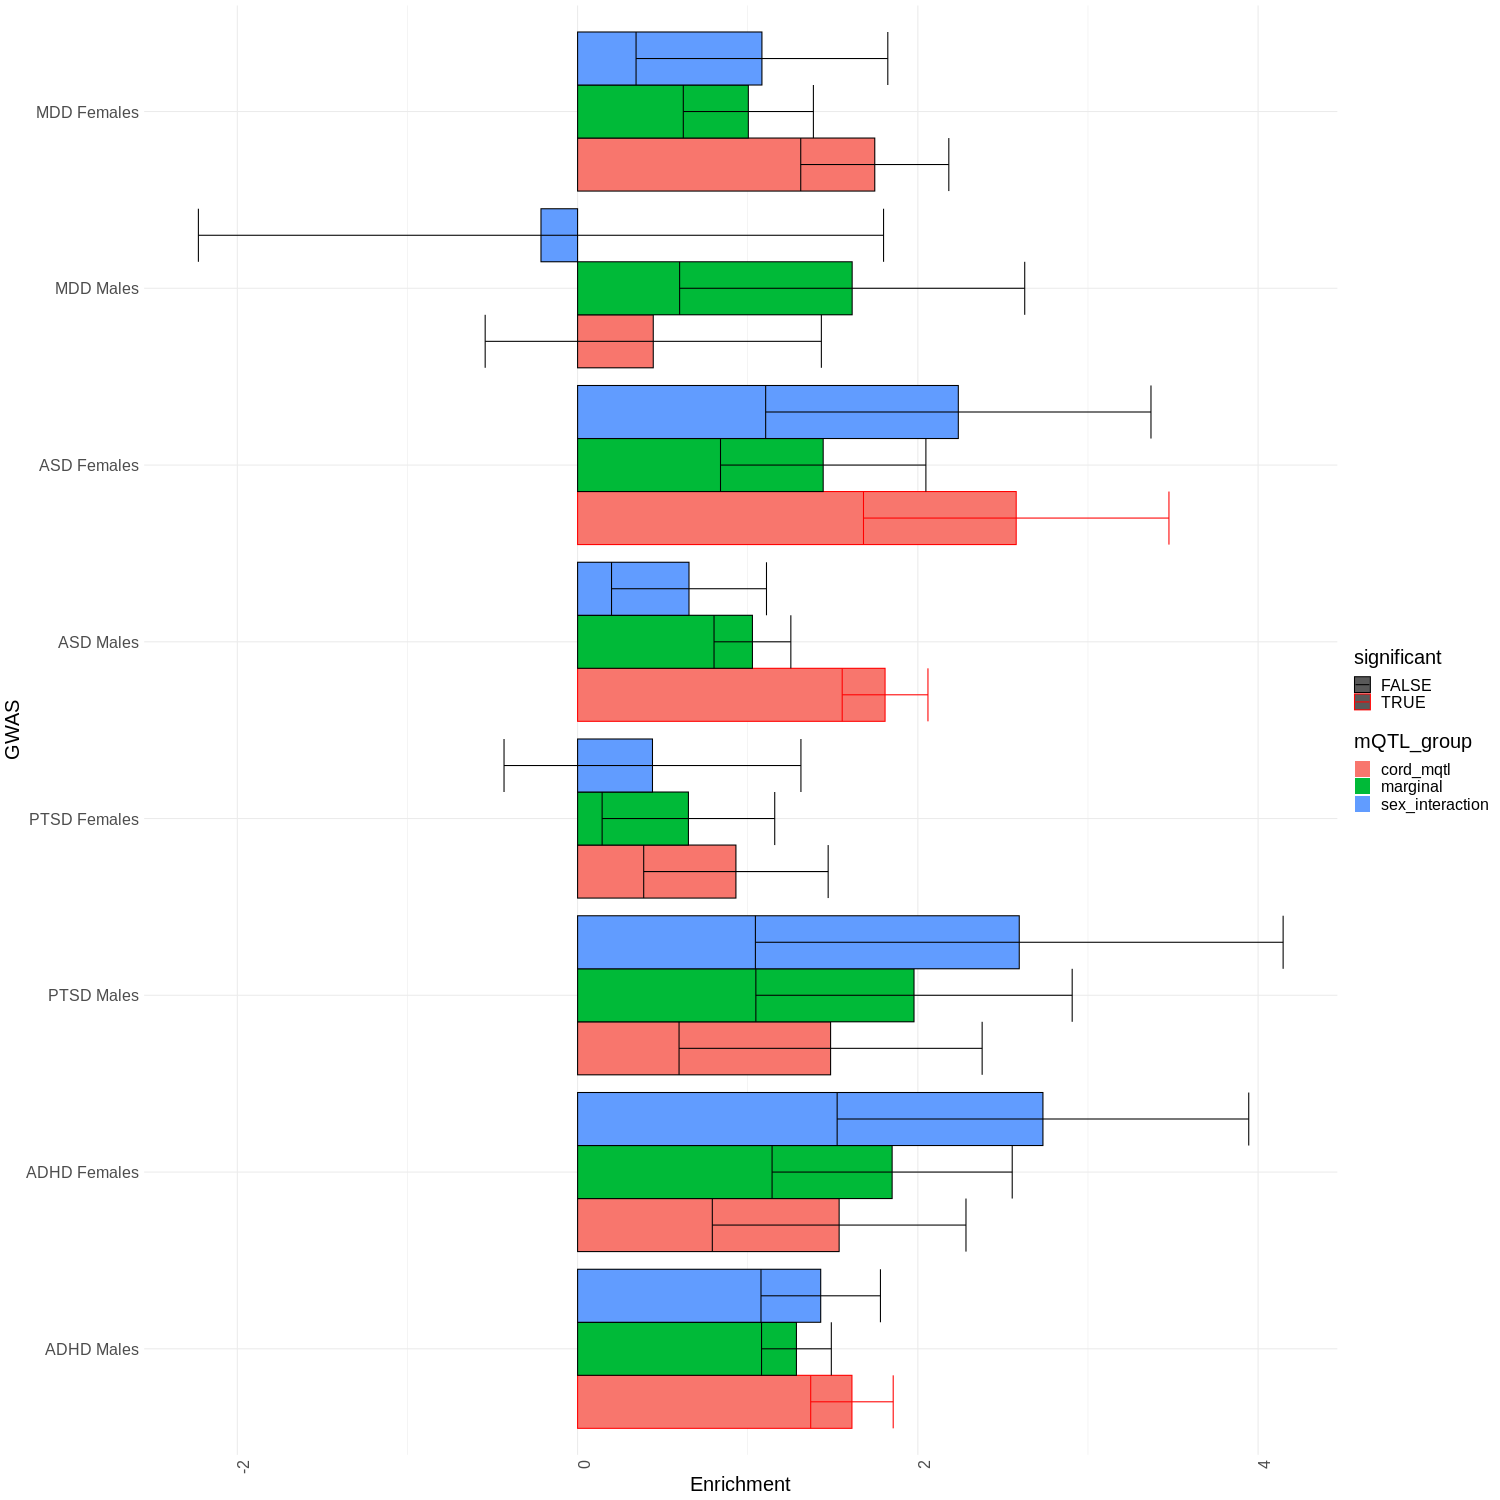

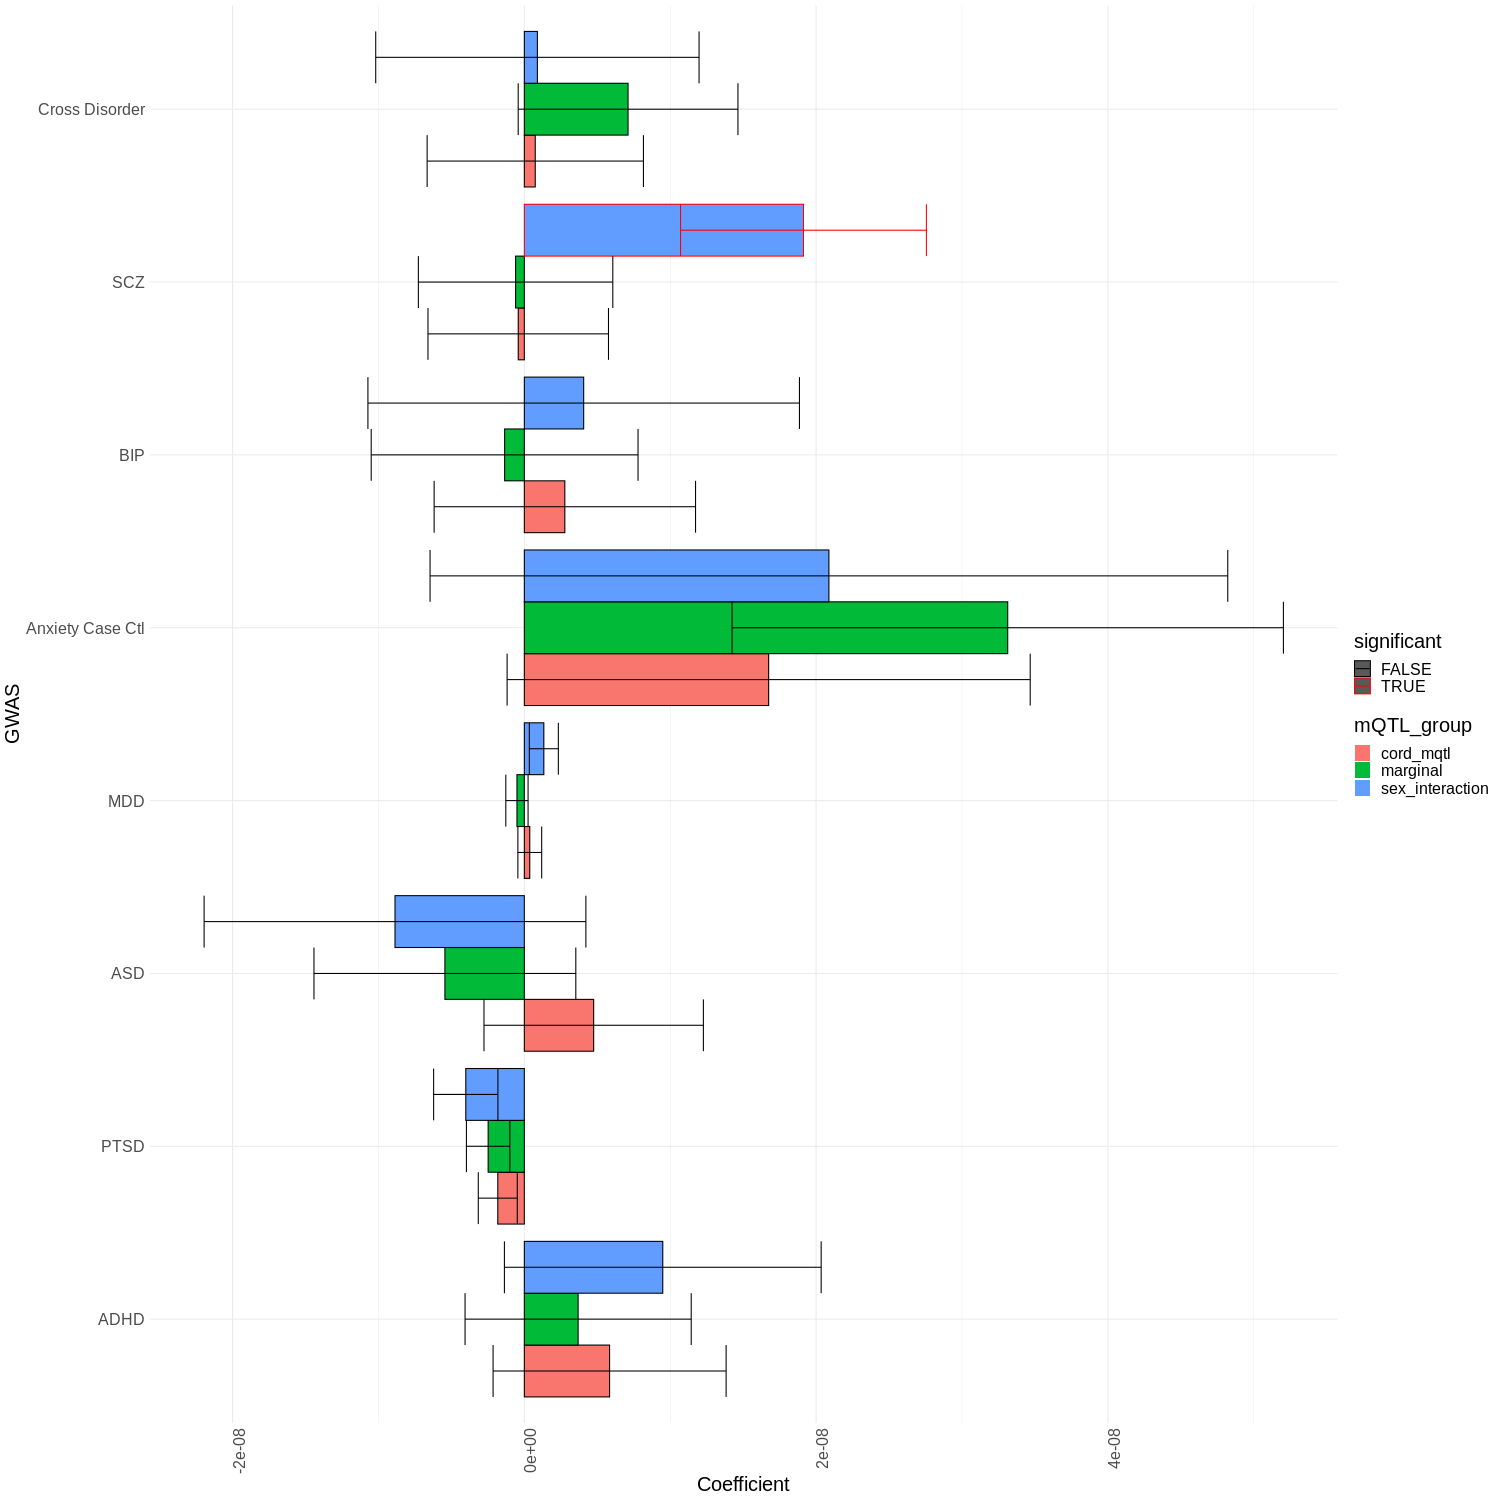

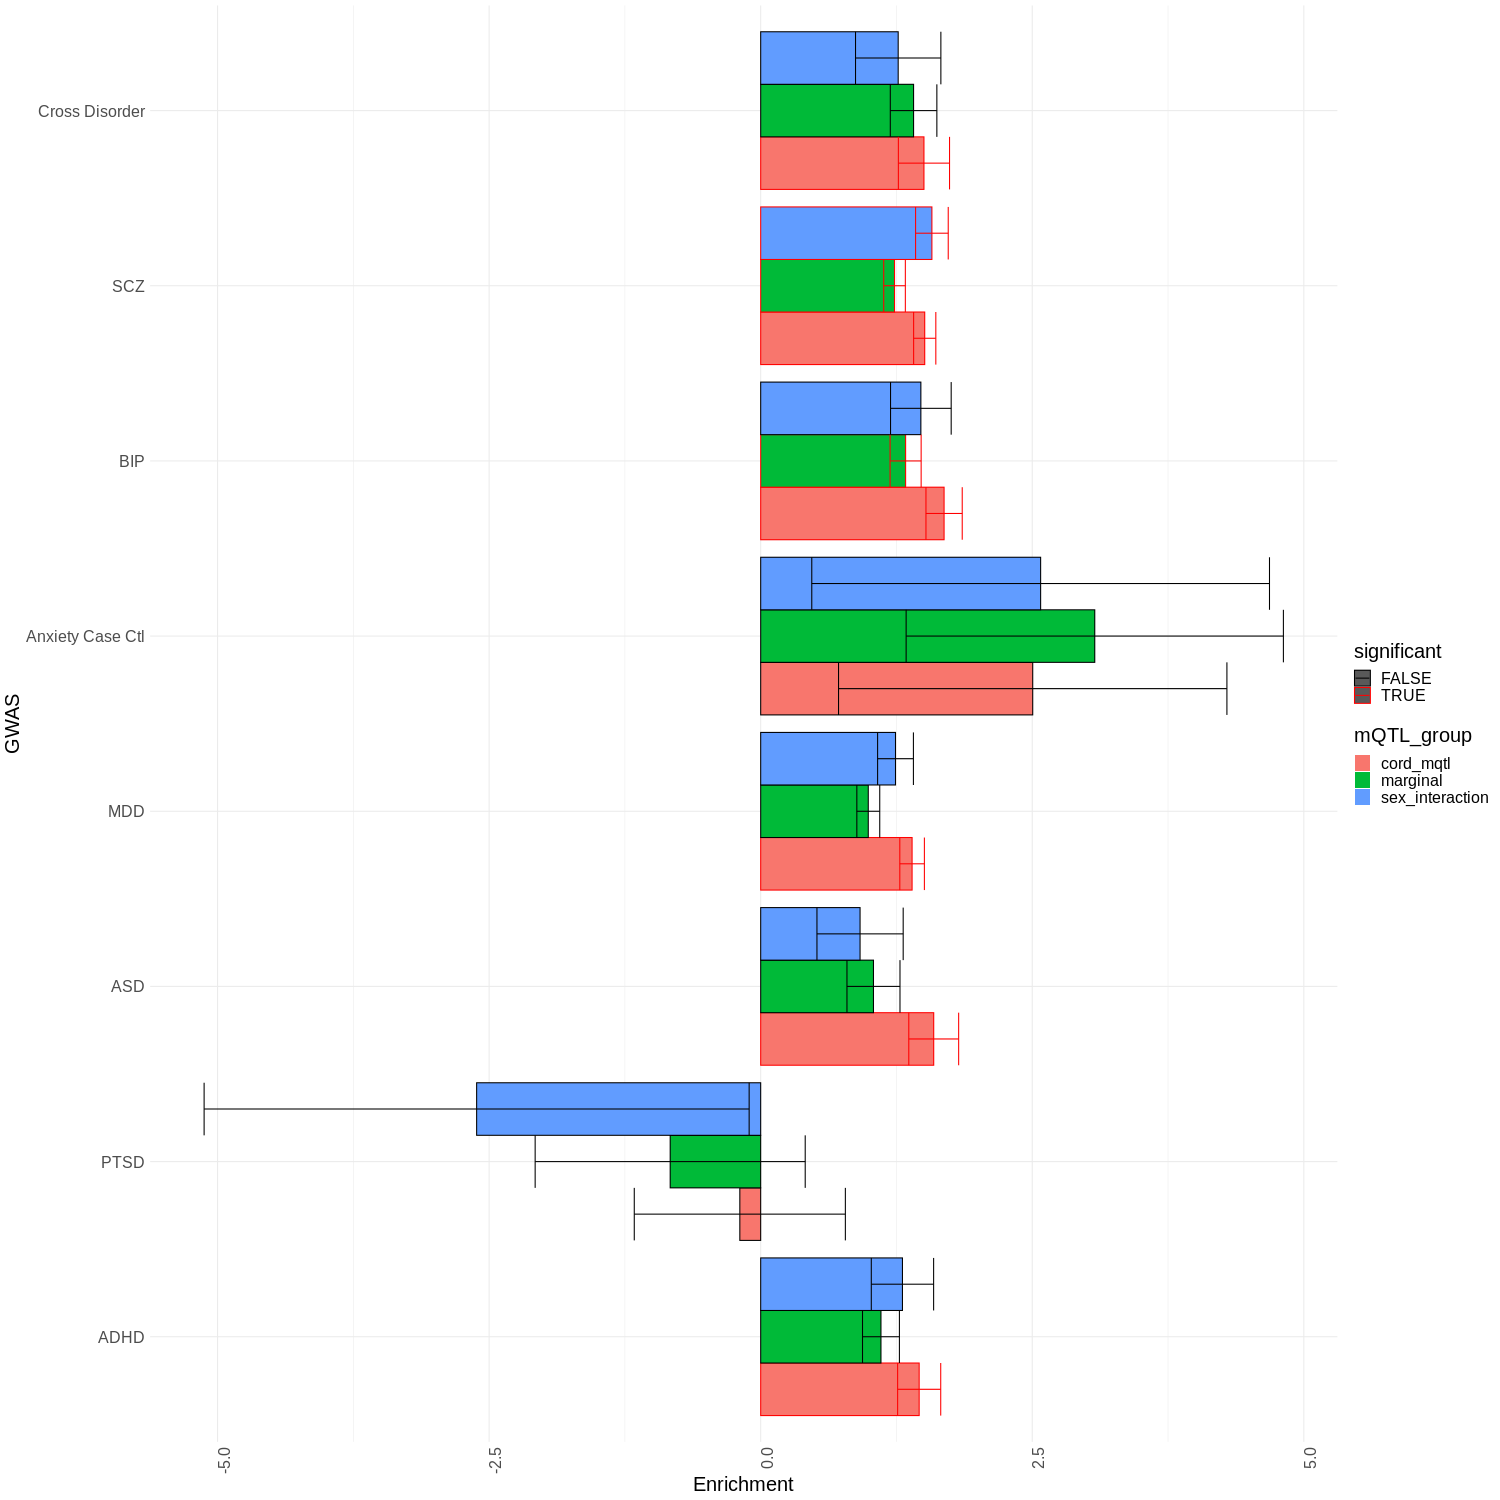

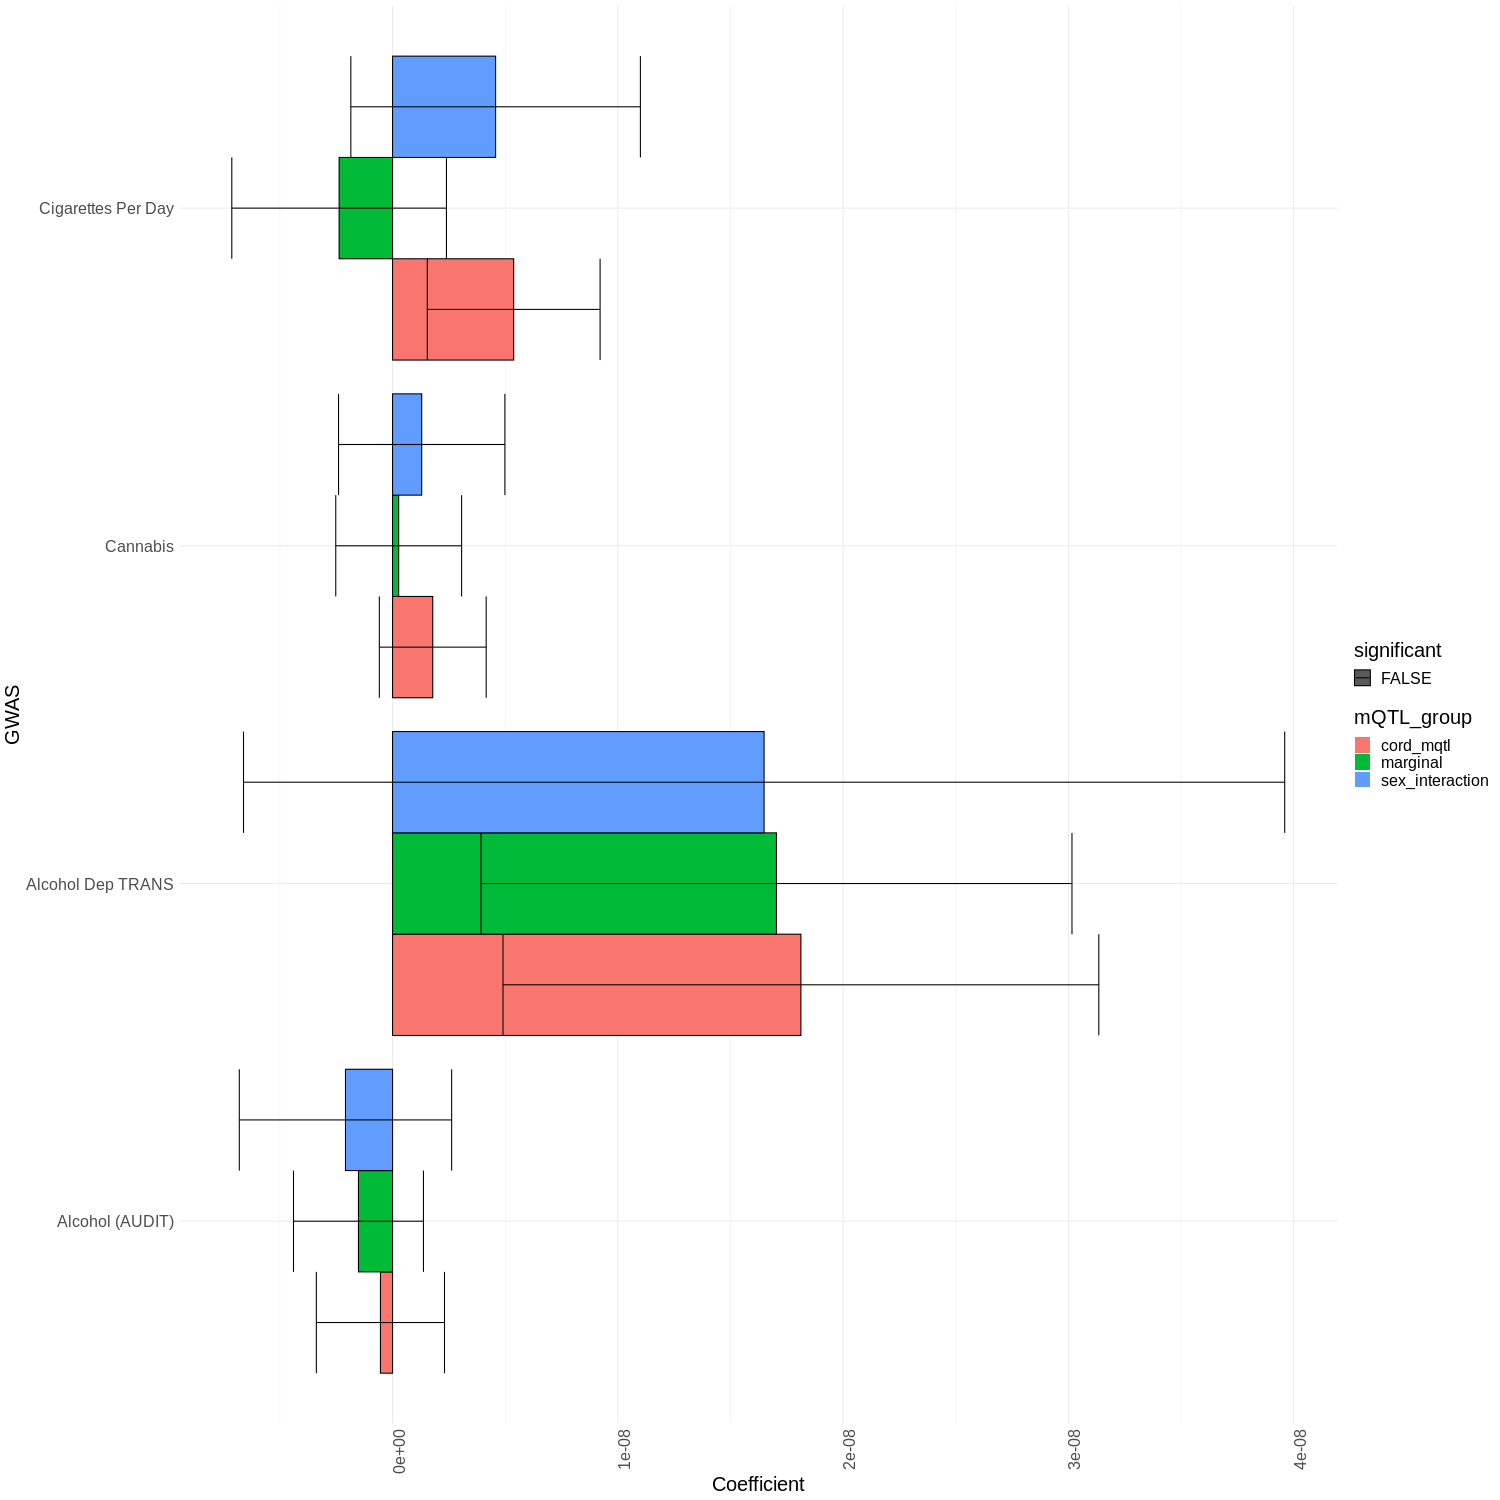

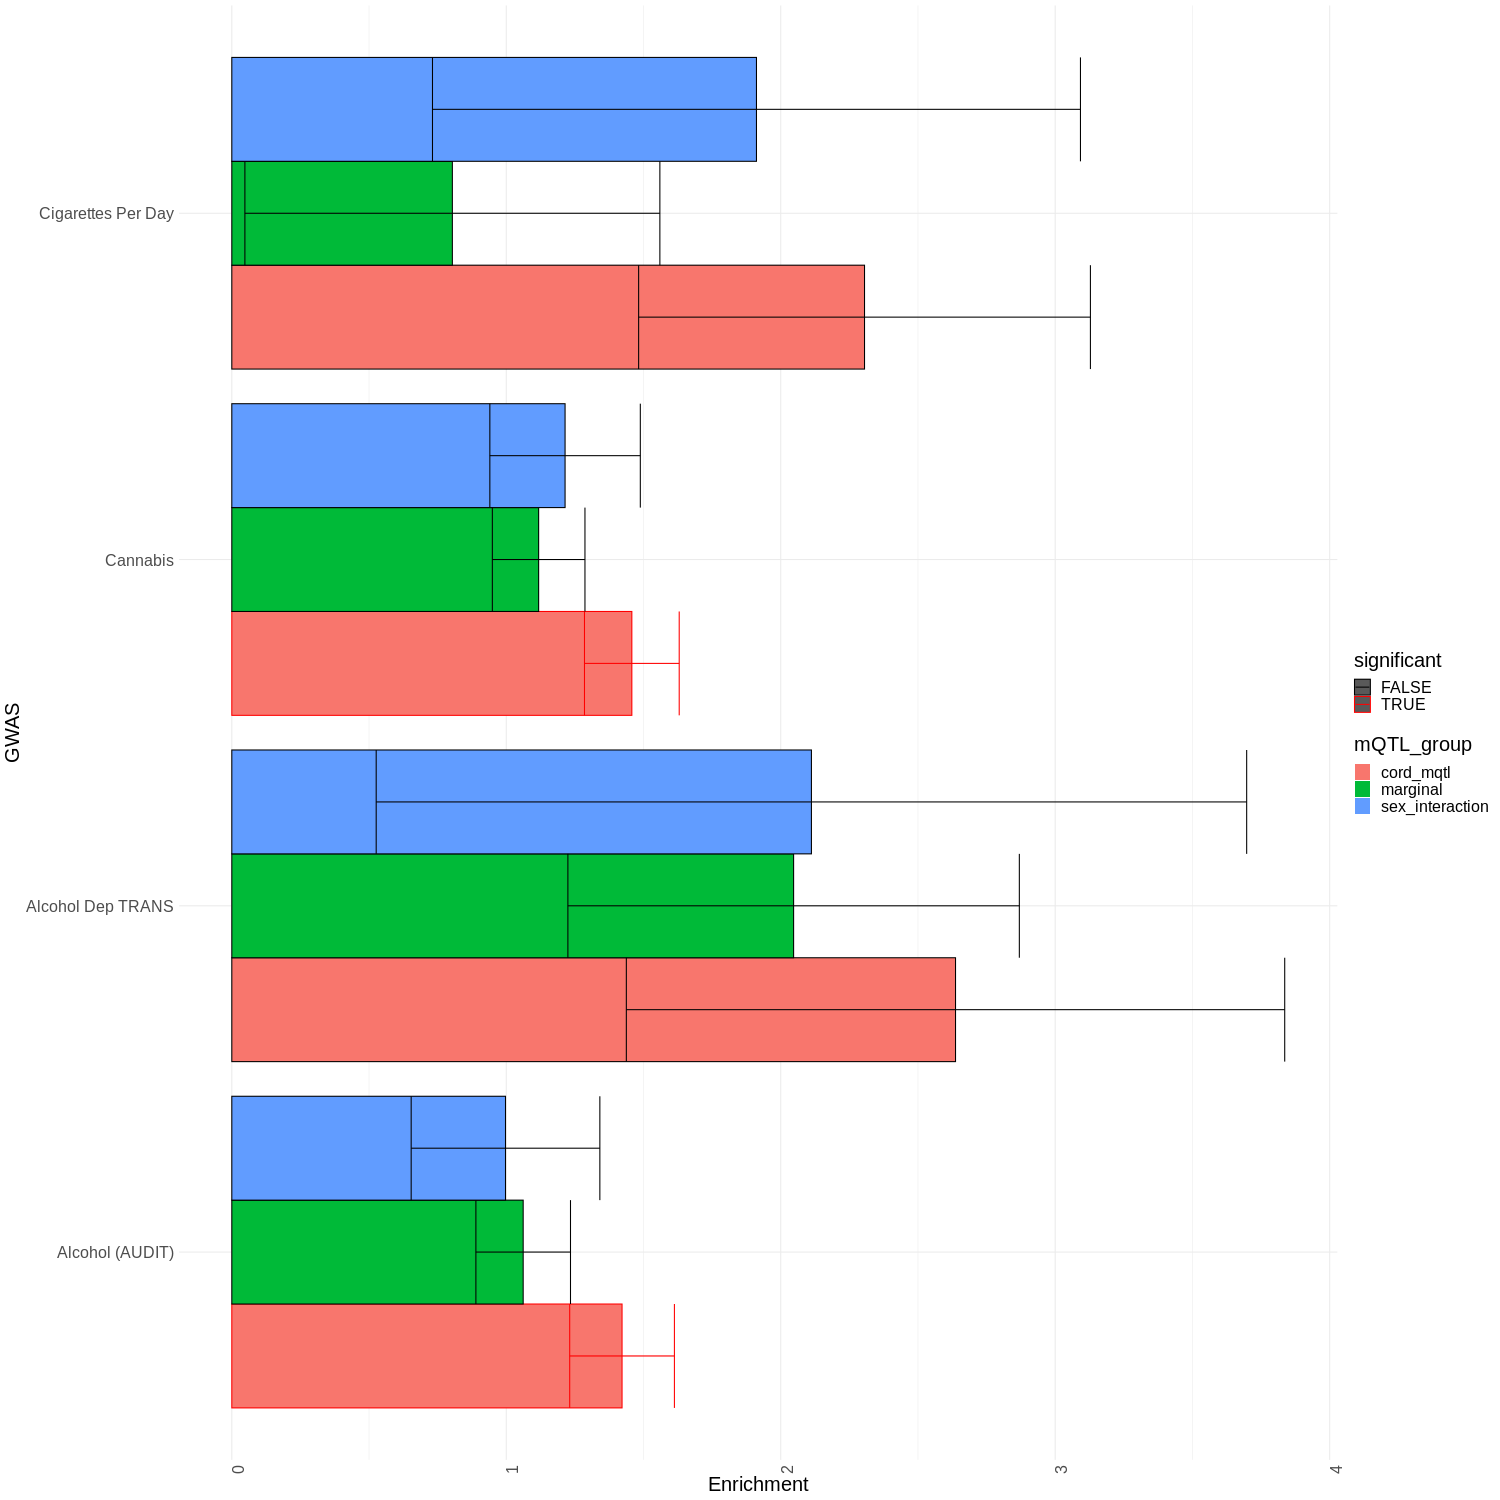

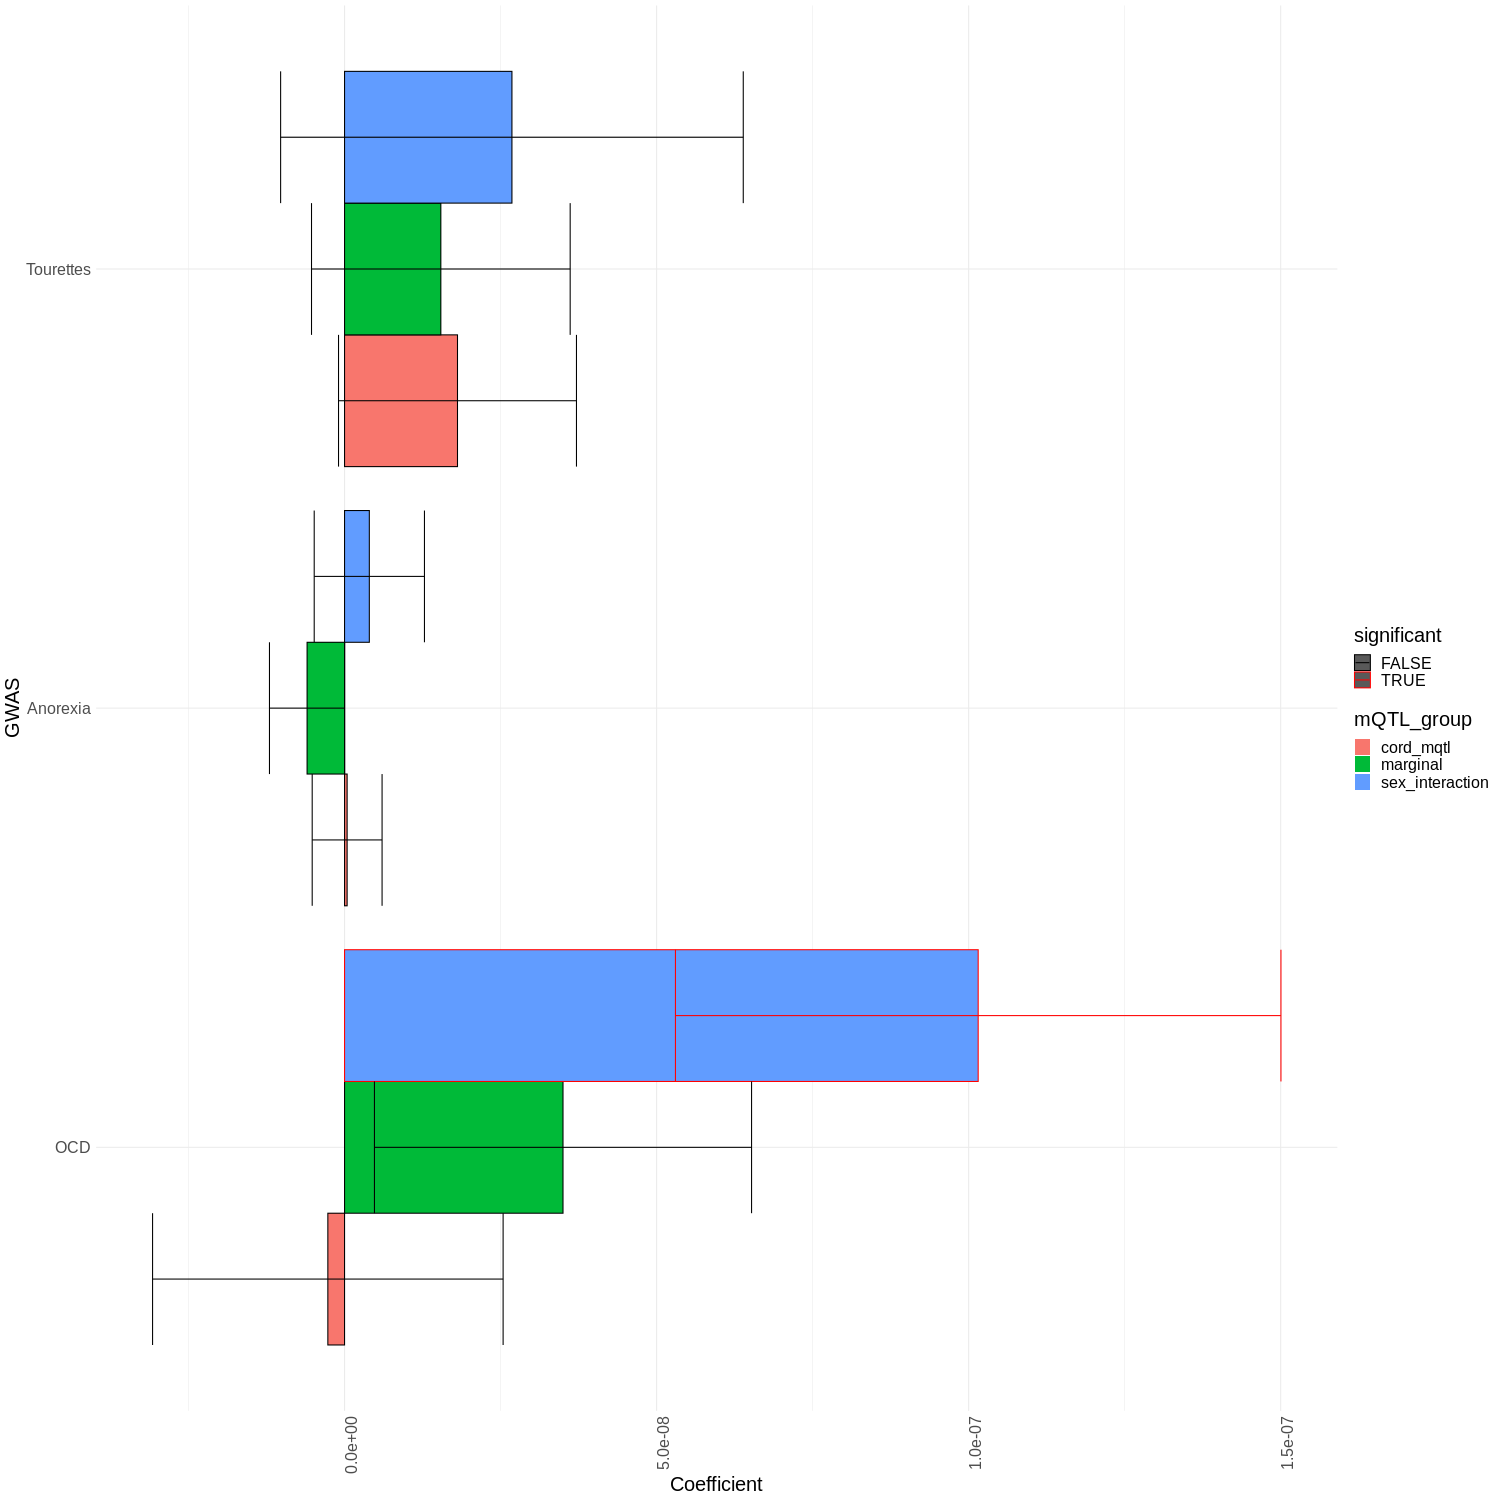

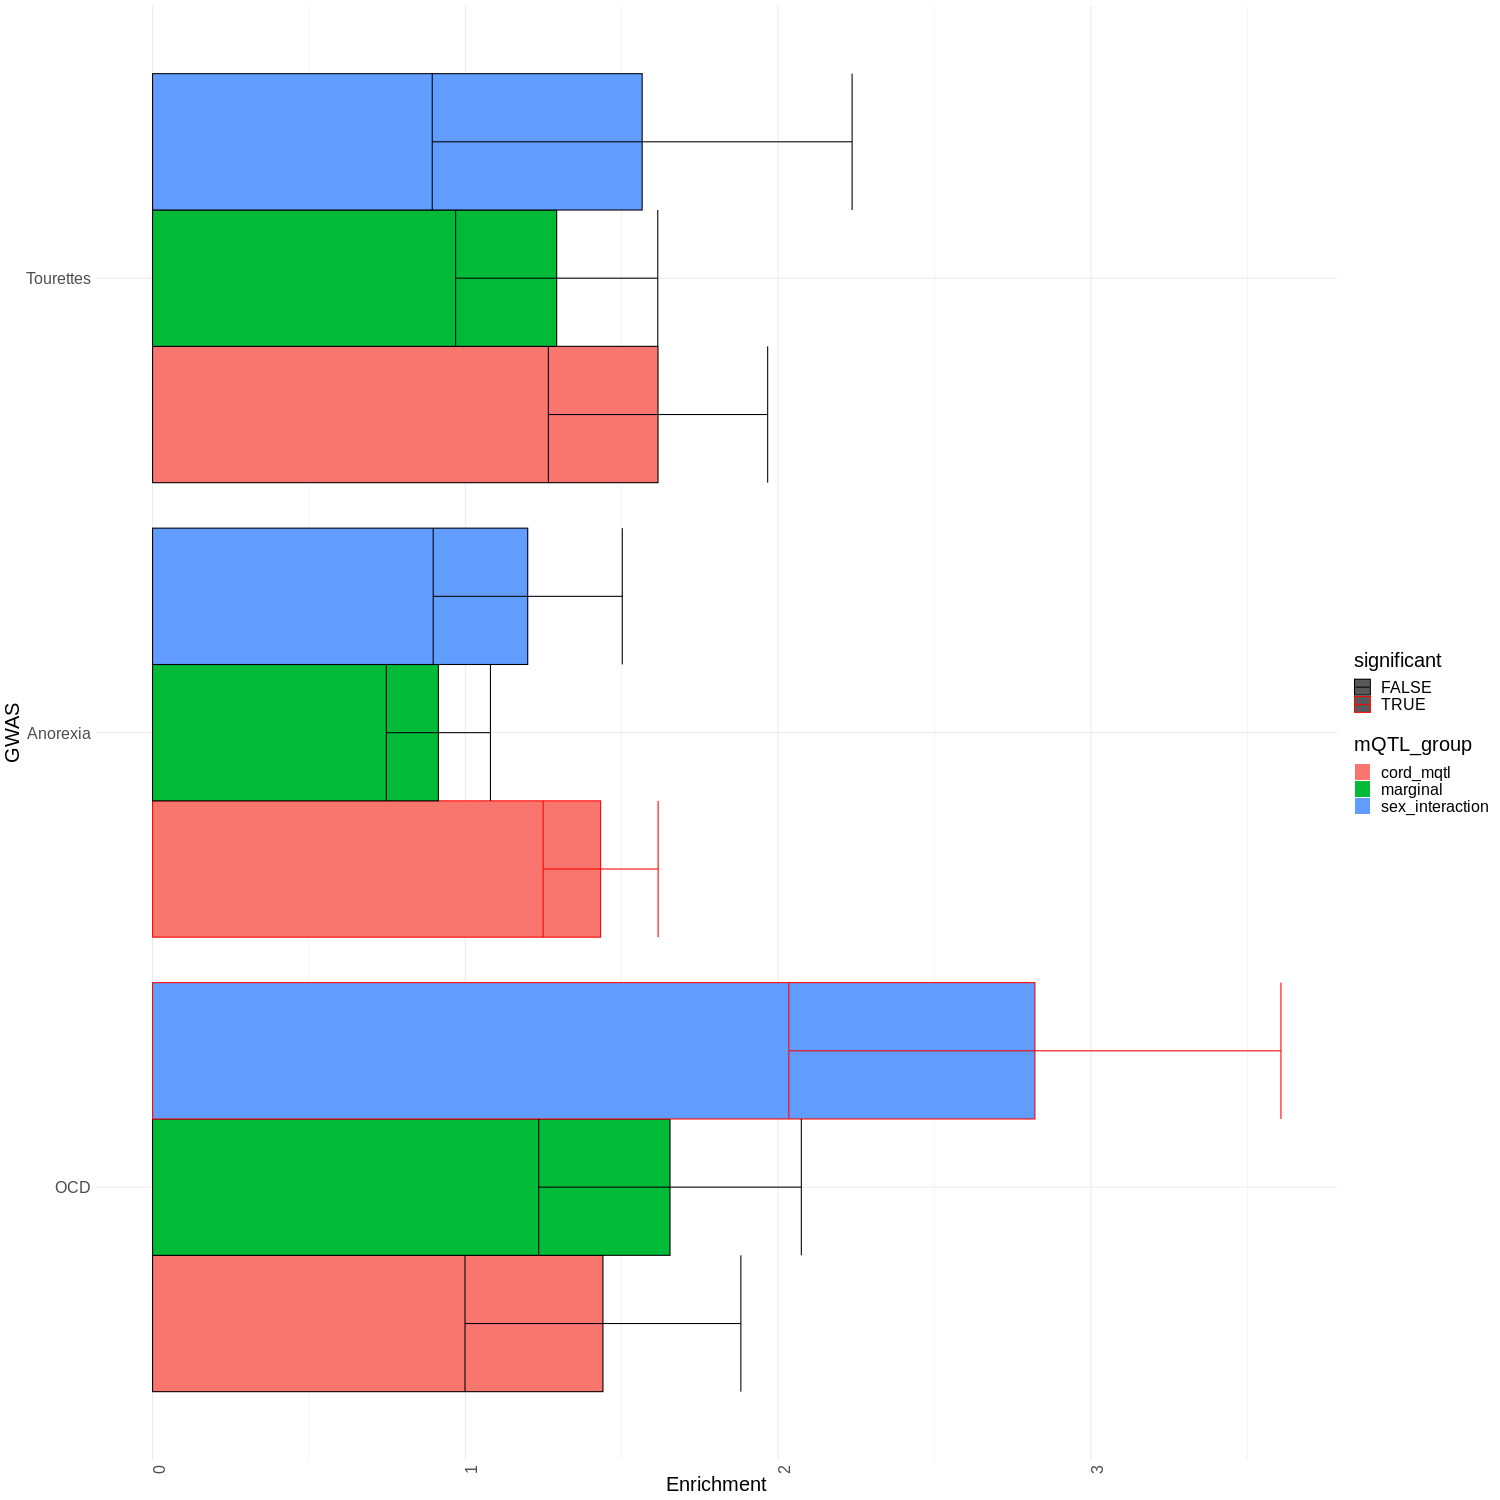

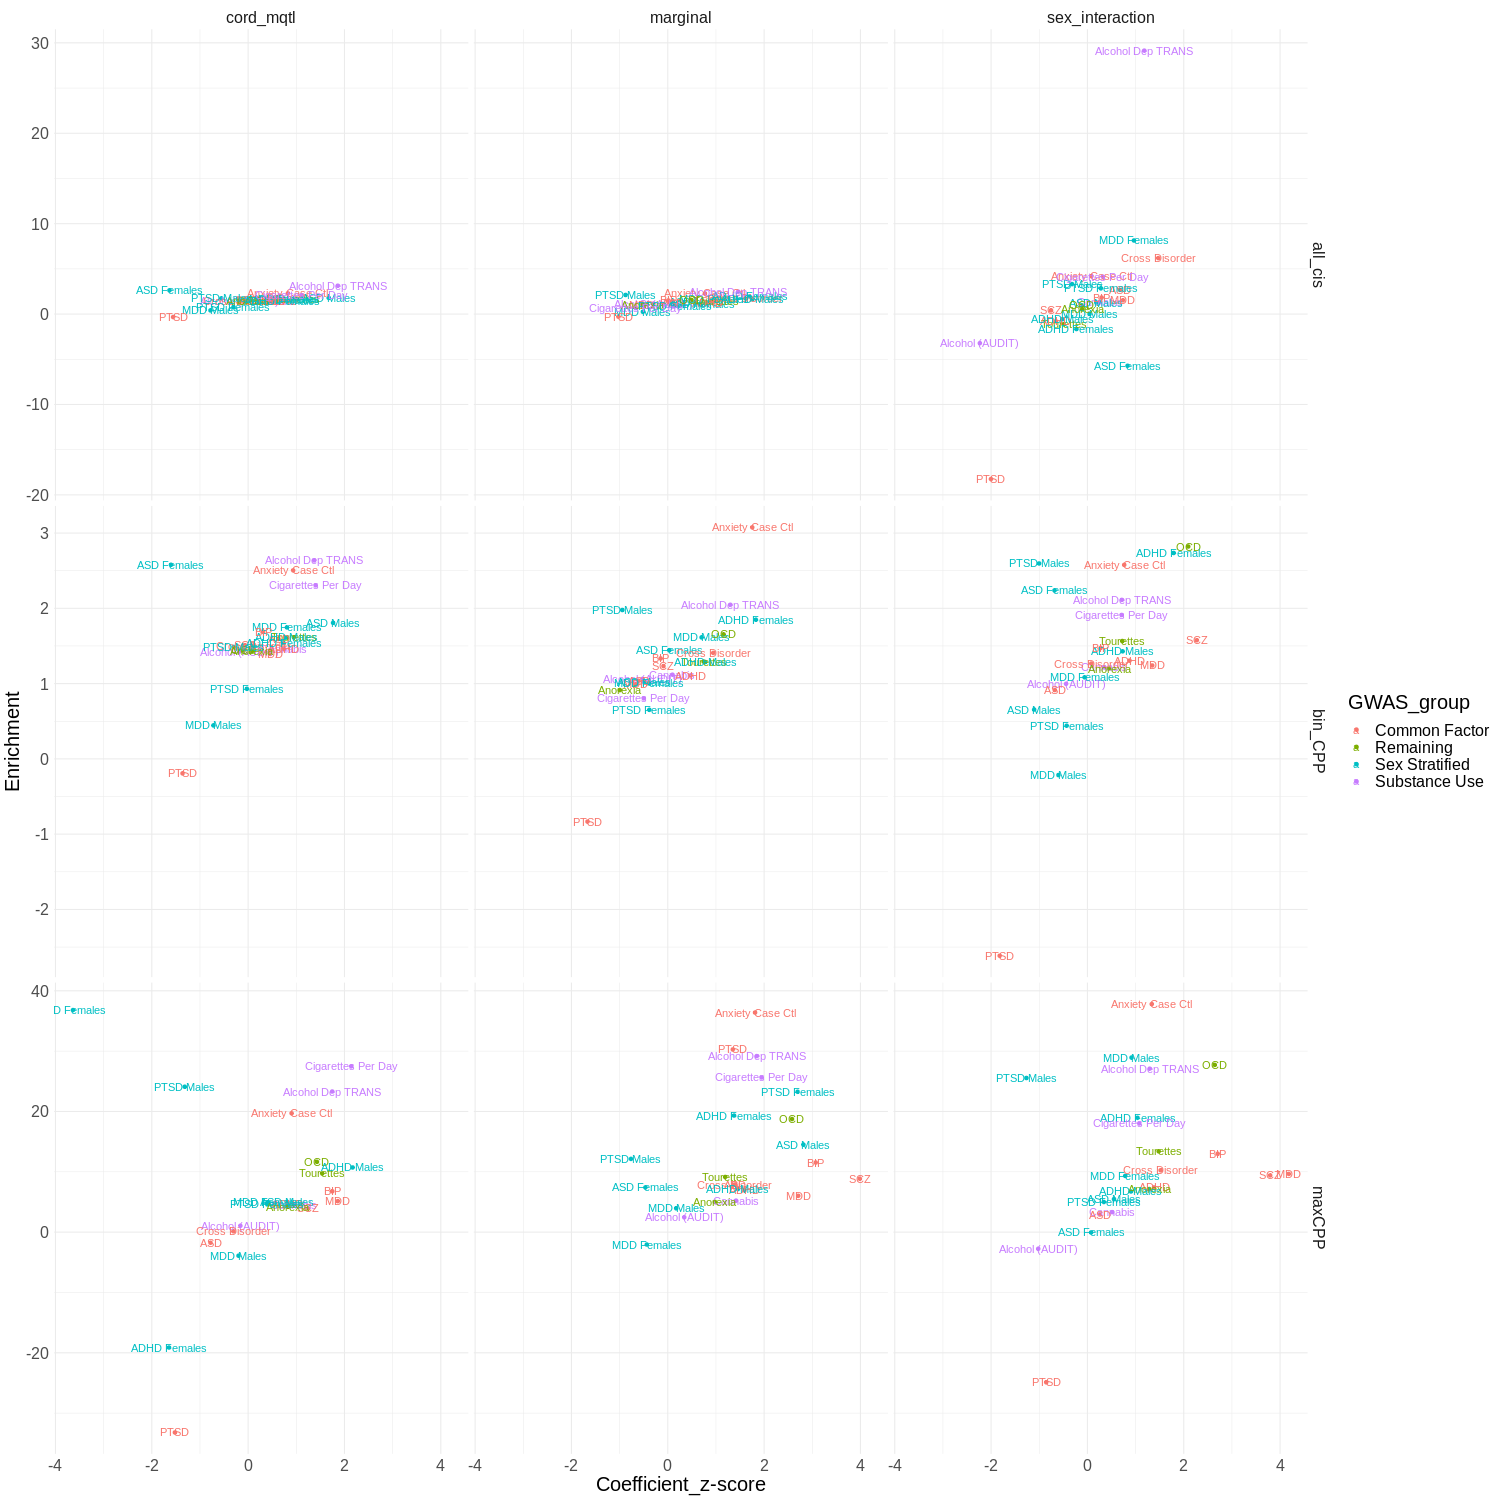

In [42]:
%%R -w 1500 -h 1500
ldsc_data <- fread("../data/ldsc_data.csv")
gwas_sample_sizes <- function(f){
    N <- fread(f,nrows=1)$N
    GWAS <- str_match(f,".*/(.*).sumstats.gz")[2]
    return(data.table(GWAS=GWAS,N=N))
}
part_heritability_results <- function(path){
    lapply(
          dir(
            path,
            pattern = "[marginal|sex_interaction|cord_mqtl].*.results$",
            full.names = TRUE
          ),
          function(f) {
            labels <- str_match(f, ".*/(marginal|sex_interaction|cord_mqtl)_(all_cis|bin_CPP|maxCPP)_(.*).results")[-c(1)]
            if (any(is.na(labels))) {
              return(data.table())
            } else {
              dt <- fread(f)[1, !"Category"]
              dt[, 
                `:=`(
                  Coefficient_p=pnorm(abs(`Coefficient_z-score`),lower.tail=F)*2,
                  mQTL_group = labels[1],
                  annotation = labels[2],
                  GWAS = labels[3])]
              return(dt)
            }
          }
        )
}

part_heritability_df <- rbindlist(part_heritability_results("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_results/"))

# ggplot(part_heritability_df, aes(x=GWAS,y=Enrichment, fill=annotation,ymin=Enrichment-Enrichment_std_error,ymax=Enrichment+Enrichment_std_error)) + geom_bar(stat='identity',position="dodge") +geom_errorbar(position="dodge") + facet_grid(annotation~mQTL_group,scales = 'free_y') + theme_minimal() +theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1))
GWAS_key <- c(
    "AD_jansen_2019"="Alzheimer's",
    "adhd_jul2017"="ADHD",
    "CAD_META"="CAD",
    "IBS_Bonfiglio"="IBS",
    "iPSYCH-PGC_ASD_Nov2017"="ASD",
    "pancancer_2020_lung"="Lung Cancer",
    "rall_SCZ"="SCZ",
    "ukbb_preeclampsia_both_sexes"="PE Both Sexes",
    "ukbb_preeclampsia_female" = "PE Females only"

)
ggplot(
        part_heritability_df %>%
        filter(!grepl("preeclampsia",GWAS)) %>%
        mutate(significant=Enrichment_p < 0.05, GWAS = recode(GWAS, !!!GWAS_key)),
        aes(
            x=GWAS,
            y=Enrichment,
            fill=annotation,
            color=significant,
            ymin=Enrichment-Enrichment_std_error,
            ymax=Enrichment+Enrichment_std_error)
    ) + 
    geom_bar(stat='identity',position="dodge") +
    geom_errorbar(position="dodge") +
    facet_grid(annotation~mQTL_group,scales = 'free_y') +
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
    scale_color_manual(values=c("black","red"),guide='none')


subset_GWAS <- c("ADHD","ASD","SCZ","IBS","Alzheimer's","CAD")
p1 <- ggplot(
        part_heritability_df %>%
        filter(!grepl("preeclampsia",GWAS),annotation == "bin_CPP") %>%
        mutate(
            significant=Enrichment_p < 0.05,
            GWAS = recode(GWAS,!!!GWAS_key),
            mQTL_group = recode(mQTL_group,marginal="Marginal",sex_interaction="Sex-Biased")
        ) %>% filter(GWAS %in% subset_GWAS ) %>% mutate(GWAS = factor(GWAS, levels= subset_GWAS)),
        aes(
            x=GWAS,
            y=Enrichment,
            fill=mQTL_group,
            color=significant,
            ymin=Enrichment-Enrichment_std_error,
            ymax=Enrichment+Enrichment_std_error)
    ) + 
    geom_bar(stat='identity',position="dodge") +
    geom_errorbar(position="dodge") +
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
    scale_color_manual(values=c("black","red"),guide=FALSE) +
    scale_fill_brewer(palette="Spectral")+
    labs(fill = "mQTL Group")+
    ggtitle("Stratified LD-Score Enrichment of\nFine-Mapped Placental mQTLs")
print(p1)
subset_GWAS <- c("ADHD","ASD","SCZ","CAD", "IBS", "Alzheimer's")
p2 <- ggplot(
        part_heritability_df %>%
            filter(!grepl("preeclampsia",GWAS))%>%
            mutate(significant = Coefficient_p < 0.05, GWAS = recode(GWAS,!!!GWAS_key)) %>% 
            filter(GWAS %in% subset_GWAS),
        aes(
            x=GWAS,
            y=Coefficient,
            fill=annotation,
            ymin=Coefficient-Coefficient_std_error,
            ymax=Coefficient+Coefficient_std_error,
            color=significant
        )
    ) + 
    geom_bar(stat='identity',position="dodge") +
    geom_errorbar(position="dodge") + 
    facet_grid(annotation~mQTL_group,scales = 'free_y') + 
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
    scale_color_manual(values=c("black","red"))
print(p2)
pgc_gwas_sample_sizes <- rbindlist(
    lapply(
        dir(
            "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats",
            pattern=".*.sumstats.gz",
            full.names=TRUE
        ),
        gwas_sample_sizes
    )
)
print(pgc_gwas_sample_sizes[order(N)])

pgc_part_heritability_df <- rbindlist(part_heritability_results("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_pgc_results/"))
pgc_part_heritability_df <- merge(pgc_part_heritability_df, pgc_gwas_sample_sizes,by="GWAS")
print(head(pgc_part_heritability_df))
print(head(ldsc_data))
pgc_part_heritability_df <- merge(pgc_part_heritability_df, ldsc_data,by=c("GWAS","mQTL_group","annotation"))
print(head(pgc_part_heritability_df))
pgc_GWAS_key <- c(
    "adhd_jul2017" = "ADHD",
    "pgc_adhd_males" = "ADHD Males",
    "pgc_adhd_females" = "ADHD Females",
    "pts_all_freeze2_overall.results" = "PTSD",
    "pts_all_freeze2_males.results" = "PTSD Males",
    "pts_all_freeze2_females.results" = "PTSD Females",
    "iPSYCH-PGC_ASD_Nov2017" = "ASD",
    "NEW_META_PGC_iPSYCH_ASD_males" = "ASD Males",
    "NEW_META_PGC_iPSYCH_ASD_females" = "ASD Females",
    "PGC_UKB_depression_genome-wide.txt" = "MDD",
    "meta_STDERR_mdd_eur_auto_M1_08_gcOFF_pgc.txt" = "MDD Males",
    "meta_STDERR_mdd_eur_auto_F1_08_gcOFF_pgc.txt" = "MDD Females",
    "ocd_aug2017" = "OCD",
    "anxiety.meta.full.cc.tbl" = "Anxiety Case Ctl",
    "anxiety.meta.full.fs.tbl" = "Anxiety Factor Scores",
    "pgc_bip_2018" = "BIP",
    "PGC3_SCZ_wave3_public.v2.tsv" = "SCZ",
    "pgcAN2.2019-07.vcf.tsv" = "Anorexia",
    "TS_Oct2018" = "Tourettes",
    "pgc.cross.full.2013-03.txt" = "Cross Disorder",
    "AUDIT_UKB_2018_AJP.txt" = "Alcohol (AUDIT)",
    "pgc_alcdep.afr_unrel_genotyped.aug2018_release.txt" = "Alcohol Dep AFR",
    "pgc_alcdep.eur_unrel_genotyped.aug2018_release.txt" = "Alcohol Dep EUR",
    "pgc_alcdep.trans_fe_unrel_geno.aug2018_release.txt" = "Alcohol Dep TRANS",
    "Cannabis_ICC_23andmetop_UKB_het.txt" = "Cannabis",
    "tag.cpd.tbl" = "Cigarettes Per Day"
)

substance_set <- c(
    "pgc_alcdep.trans_fe_unrel_geno.aug2018_release.txt" = "Alcohol Dep TRANS",
    "Cannabis_ICC_23andmetop_UKB_het.txt" = "Cannabis",
    "tag.cpd.tbl" = "Cigarettes Per Day",
    "AUDIT_UKB_2018_AJP.txt" = "Alcohol (AUDIT)"
)
common_factor_set <- c(
    "pgc.cross.full.2013-03.txt" = "Cross Disorder",
    "adhd_jul2017" = "ADHD",
    "pts_all_freeze2_overall.results" = "PTSD",
    "iPSYCH-PGC_ASD_Nov2017" = "ASD",
    "PGC_UKB_depression_genome-wide.txt" = "MDD",
    "anxiety.meta.full.cc.tbl" = "Anxiety Case Ctl",
    "pgc_bip_2018" = "BIP",
    "PGC3_SCZ_wave3_public.v2.tsv" = "SCZ"
)

remainder_set <- c(
    "ocd_aug2017" = "OCD",
    "pgcAN2.2019-07.vcf.tsv" = "Anorexia",
    "TS_Oct2018" = "Tourettes"
)
sex_stratified_set <- c(
    "pgc_adhd_males" = "ADHD Males",
    "pgc_adhd_females" = "ADHD Females",
    "pts_all_freeze2_males.results" = "PTSD Males",
    "pts_all_freeze2_females.results" = "PTSD Females",
    "NEW_META_PGC_iPSYCH_ASD_males" = "ASD Males",
    "NEW_META_PGC_iPSYCH_ASD_females" = "ASD Females",
    "meta_STDERR_mdd_eur_auto_M1_08_gcOFF_pgc.txt" = "MDD Males",
    "meta_STDERR_mdd_eur_auto_F1_08_gcOFF_pgc.txt" = "MDD Females"
)
p3 <- ggplot(
        pgc_part_heritability_df %>%
            filter(annotation %in% c("bin_CPP"), GWAS %in% names(sex_stratified_set)) %>%
            mutate(
                significant = Coefficient_p < 0.05, 
                GWAS = recode(GWAS, !!!pgc_GWAS_key)
            ) %>%
            mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key)),
        aes(
            x=GWAS,
            y=Coefficient,
            fill=mQTL_group,
            ymin=Coefficient-Coefficient_std_error,
            ymax=Coefficient+Coefficient_std_error,
            color = significant
        )
    ) + 
    geom_bar(position="dodge",stat="identity")+
    geom_errorbar(position="dodge")+
    coord_flip() + 
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1), text=element_text(size=20))+
    scale_color_manual(values=c("black","red"))
print(p3)
p4 <- ggplot(
        pgc_part_heritability_df %>%
            filter(annotation == "bin_CPP",  GWAS %in% names(sex_stratified_set)) %>%
            mutate(
                significant = Enrichment_p < 0.05,
                GWAS = recode(GWAS, !!!pgc_GWAS_key)
            )%>%
            mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key)),
        aes(
            x=GWAS,
            y=Enrichment,
            fill=mQTL_group,
            ymin=Enrichment-Enrichment_std_error,
            ymax=Enrichment+Enrichment_std_error,
            color=significant
        )
    ) + 
    geom_bar(stat='identity',position="dodge") +
    geom_errorbar(position="dodge")+
    coord_flip() +
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1), text=element_text(size=20))+
    scale_color_manual(values=c("black","red"))
print(p4)
p3 <- ggplot(
        pgc_part_heritability_df %>%
            filter(annotation %in% c("bin_CPP"), GWAS %in% names(common_factor_set)) %>%
            mutate(
                significant = Coefficient_p < 0.05, 
                GWAS = recode(GWAS, !!!pgc_GWAS_key)
            ) %>%
            mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key)),
        aes(
            x=GWAS,
            y=Coefficient,
            fill=mQTL_group,
            ymin=Coefficient-Coefficient_std_error,
            ymax=Coefficient+Coefficient_std_error,
            color = significant
        )
    ) + 
    geom_bar(position="dodge",stat="identity")+
    geom_errorbar(position="dodge")+
    coord_flip() + 
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1), text=element_text(size=20))+
    scale_color_manual(values=c("black","red"))
print(p3)
p4 <- ggplot(
        pgc_part_heritability_df %>%
            filter(annotation == "bin_CPP",  GWAS %in% names(common_factor_set)) %>%
            mutate(
                significant = Enrichment_p < 0.05,
                GWAS = recode(GWAS, !!!pgc_GWAS_key)
            )%>%
            mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key)),
        aes(
            x=GWAS,
            y=Enrichment,
            fill=mQTL_group,
            ymin=Enrichment-Enrichment_std_error,
            ymax=Enrichment+Enrichment_std_error,
            color=significant
        )
    ) + 
    geom_bar(stat='identity',position="dodge") +
    geom_errorbar(position="dodge")+
    coord_flip() +
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1), text=element_text(size=20))+
    scale_color_manual(values=c("black","red"))
print(p4)
p3 <- ggplot(
        pgc_part_heritability_df %>%
            filter(annotation %in% c("bin_CPP"), GWAS %in% names(substance_set)) %>%
            mutate(
                significant = Coefficient_p < 0.05, 
                GWAS = recode(GWAS, !!!pgc_GWAS_key)
            ) %>%
            mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key)),
        aes(
            x=GWAS,
            y=Coefficient,
            fill=mQTL_group,
            ymin=Coefficient-Coefficient_std_error,
            ymax=Coefficient+Coefficient_std_error,
            color = significant
        )
    ) + 
    geom_bar(position="dodge",stat="identity")+
    geom_errorbar(position="dodge")+
    coord_flip() + 
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1), text=element_text(size=20))+
    scale_color_manual(values=c("black","red"))
print(p3)
p4 <- ggplot(
        pgc_part_heritability_df %>%
            filter(annotation == "bin_CPP",  GWAS %in% names(substance_set)) %>%
            mutate(
                significant = Enrichment_p < 0.05,
                GWAS = recode(GWAS, !!!pgc_GWAS_key)
            )%>%
            mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key)),
        aes(
            x=GWAS,
            y=Enrichment,
            fill=mQTL_group,
            ymin=Enrichment-Enrichment_std_error,
            ymax=Enrichment+Enrichment_std_error,
            color=significant
        )
    ) + 
    geom_bar(stat='identity',position="dodge") +
    geom_errorbar(position="dodge")+
    coord_flip() +
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1), text=element_text(size=20))+
    scale_color_manual(values=c("black","red"))
print(p4)
p3 <- ggplot(
        pgc_part_heritability_df %>%
            filter(annotation %in% c("bin_CPP"), GWAS %in% names(remainder_set)) %>%
            mutate(
                significant = Coefficient_p < 0.05, 
                GWAS = recode(GWAS, !!!pgc_GWAS_key)
            ) %>%
            mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key)),
        aes(
            x=GWAS,
            y=Coefficient,
            fill=mQTL_group,
            ymin=Coefficient-Coefficient_std_error,
            ymax=Coefficient+Coefficient_std_error,
            color = significant
        )
    ) + 
    geom_bar(position="dodge",stat="identity")+
    geom_errorbar(position="dodge")+
    coord_flip() + 
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1), text=element_text(size=20))+
    scale_color_manual(values=c("black","red"))
print(p3)
p4 <- ggplot(
        pgc_part_heritability_df %>%
            filter(annotation == "bin_CPP",  GWAS %in% names(remainder_set)) %>%
            mutate(
                significant = Enrichment_p < 0.05,
                GWAS = recode(GWAS, !!!pgc_GWAS_key)
            )%>%
            mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key)),
        aes(
            x=GWAS,
            y=Enrichment,
            fill=mQTL_group,
            ymin=Enrichment-Enrichment_std_error,
            ymax=Enrichment+Enrichment_std_error,
            color=significant
        )
    ) + 
    geom_bar(stat='identity',position="dodge") +
    geom_errorbar(position="dodge")+
    coord_flip() +
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1), text=element_text(size=20))+
    scale_color_manual(values=c("black","red"))
print(p4)

gwas_groups <- c(
        rep("Common Factor", length(common_factor_set)),
        rep("Substance Use", length(substance_set)),
        rep("Remaining", length(remainder_set)),
        rep("Sex Stratified", length(sex_stratified_set))
    )
names(gwas_groups) <- c(
    names(common_factor_set),
    names(substance_set),
    names(remainder_set),
    names(sex_stratified_set)
)
p4 <- ggplot(
        pgc_part_heritability_df %>%
            mutate(
                GWAS_group=gwas_groups[GWAS],
                GWAS = recode(GWAS, !!!pgc_GWAS_key)
            )%>%
            filter(!is.na(GWAS_group)) %>%
            mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key)),
        aes(
            x=`Coefficient_z-score`,
            y=Enrichment,
            color=GWAS_group
        )
    ) + 
    geom_point() +
    geom_text(aes(label=GWAS)) +
    facet_grid(annotation~mQTL_group,scales="free_y")+
    theme_minimal() +
    theme(text=element_text(size=20))
print(p4)
# adhd_asd_data <-         pgc_part_heritability_df %>%
#             filter(annotation == "bin_CPP",  mQTL_group != "cord_mqtl") %>%
#             mutate(
#                 significant = Enrichment_p < 0.05,
#                 GWAS = recode(GWAS, !!!pgc_GWAS_key),
#                 `Annotation` = recode(mQTL_group,"sex_interaction"="Sex Biased", "marginal"="Marginal")
#             )%>%
#             mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key)) %>%
#             filter(grepl("ADHD|ASD",GWAS))
# adhd_asd_data %>% write.csv(quote=FALSE,row.names=FALSE)

# p4 <- ggplot(
#         adhd_asd_data,
#         aes(
#             x=GWAS,
#             y=Enrichment,
#             fill=Annotation,
#             ymin=Enrichment-Enrichment_std_error,
#             ymax=Enrichment+Enrichment_std_error,
#         )
#     ) + 
#     geom_bar(stat='identity',position="dodge") +
#     geom_errorbar(position="dodge")+
#     coord_flip() +
#     theme_minimal() +
#     scale_fill_aaas()
# print(p4)




# p4 <- ggplot(
#         pgc_part_heritability_df %>%
#             filter(annotation == "bin_CPP") %>%
#             mutate(
#                 significant = Enrichment_p < 0.05,
#                 GWAS = recode(GWAS, !!!pgc_GWAS_key)
#             ),
#         aes(
#             x=snps * Prop._SNPs,
#             y=Enrichment,
#             shape=mQTL_group,
#             color=significant
#         )
#     ) + 
#     geom_point(size=2) +  
#     theme_minimal() +
#     theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
#     scale_color_manual(values=c("black","red"))

# print(p4)

# p4 <- ggplot(
#         pgc_part_heritability_df %>%
#             filter(annotation == "bin_CPP") %>%
#             mutate(
#                 significant = Enrichment_p < 0.05,
#                 GWAS = recode(GWAS, !!!pgc_GWAS_key)
#             ),
#         aes(
#             x=snps * Prop._SNPs,
#             y=Enrichment_std_error,
#             shape=mQTL_group,
#             color=significant
#         )
#     ) + 
#     geom_point(size=2) +
#     theme_minimal() +
#     theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
#     scale_color_manual(values=c("black","red"))

# print(p4)
# p4 <- ggplot(
#         pgc_part_heritability_df %>%
#             filter(annotation == "bin_CPP") %>%
#             mutate(
#                 significant = Enrichment_p < 0.05,
#                 GWAS = recode(GWAS, !!!pgc_GWAS_key)
#             ),
#         aes(
#             x=Prop._SNPs,
#             y=Enrichment,
#             shape=mQTL_group,
#             color=significant
#         )
#     ) + 
#     geom_point(size = 2) +
#     theme_minimal() +
#     theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
#     scale_color_manual(values=c("black","red"))

# print(p4)

# p4 <- ggplot(
#         pgc_part_heritability_df %>%
#             filter(annotation == "bin_CPP") %>%
#             mutate(
#                 significant = Enrichment_p < 0.05,
#                 GWAS = recode(GWAS, !!!pgc_GWAS_key)
#             ),
#         aes(
#             x=Prop._SNPs,
#             y=Enrichment_std_error,
#             shape=mQTL_group,
#             color=significant
#         )
#     ) + 
#     geom_point(size = 2) +
#     theme_minimal() +
#     theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
#     scale_color_manual(values=c("black","red"))

# print(p4)

# p4 <- ggplot(
#         pgc_part_heritability_df %>%
#             filter(annotation == "bin_CPP") %>%
#             mutate(
#                 significant = Enrichment_p < 0.05,
#                 GWAS = recode(GWAS, !!!pgc_GWAS_key)
#             ),
#         aes(
#             x=N,
#             y=Enrichment,
#             shape=mQTL_group,
#             color=significant
#         )
#     ) + 
#     geom_point(size = 2) +
#     theme_minimal() +
#     theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
#     scale_color_manual(values=c("black","red"))
# print(p4)
# p4 <- ggplot(
#         pgc_part_heritability_df %>%
#             filter(annotation == "bin_CPP") %>%
#             mutate(
#                 significant = Enrichment_p < 0.05,
#                 GWAS = recode(GWAS, !!!pgc_GWAS_key)
#             ),
#         aes(
#             x=N,
#             y=Enrichment_std_error,
#             shape=mQTL_group,
#             color=significant
#         )
#     ) + 
#     geom_point(size = 2) +  
#     theme_minimal() +
#     theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
#     scale_color_manual(values=c("black","red"))
# print(p4)
# p4 <- ggplot(
#         pgc_part_heritability_df %>%
#             filter(annotation == "bin_CPP") %>%
#             mutate(
#                 significant = Enrichment_p < 0.05,
#                 GWAS = recode(GWAS, !!!pgc_GWAS_key)
#             ) %>% group_by(GWAS) %>% mutate(h2 = mean(h2)),
#         aes(
#             x=h2,
#             y=Enrichment_std_error,
#             shape=mQTL_group,
#             color=significant
#         )
#     ) + 
#     geom_point(size = 2) +  
#     theme_minimal() +
#     theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
#     scale_color_manual(values=c("black","red"))
# print(p4)
# p4 <- ggplot(
#         pgc_part_heritability_df %>%
#             filter(annotation == "bin_CPP") %>%
#             mutate(
#                 significant = Enrichment_p < 0.05,
#                 GWAS = recode(GWAS, !!!pgc_GWAS_key)
#             ),
#         aes(
#             x=mQTL_group,
#             y=Enrichment_std_error,
#             fill=mQTL_group,
#         )
#     ) + 
#     geom_boxplot() +
#     geom_point(size = 2) +  
#     theme_minimal() +
#     theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) 
# print(p4)

# p4 <- ggplot(
#         pgc_part_heritability_df %>%
#             filter(annotation == "bin_CPP", mQTL_group %in% c("cord_mqtl", "marginal")) %>%
#             mutate(
#                 significant = Enrichment_p < 0.05,
#                 GWAS = recode(GWAS, !!!pgc_GWAS_key)
#             ),
#         aes(
#             x=GWAS,
#             y=Enrichment,
#             fill=mQTL_group,
#             ymin=Enrichment-Enrichment_std_error,
#             ymax=Enrichment+Enrichment_std_error,
#             color=significant
#         )
#     ) + 
#     geom_bar(stat='identity',position="dodge") +
#     coord_flip() +
#     geom_errorbar(position="dodge") +  
#     theme_minimal() +
#     theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
#     scale_color_manual(values=c("black","red"))
# print(p4)

# p4 <- ggplot(
#         pgc_part_heritability_df %>%
#             filter(annotation == "bin_CPP", mQTL_group %in% c("cord_mqtl", "sex_interaction")) %>%
#             mutate(
#                 significant = Enrichment_p < 0.05,
#                 GWAS = recode(GWAS, !!!pgc_GWAS_key)
#             ),
#         aes(
#             x=GWAS,
#             y=Enrichment,
#             fill=mQTL_group,
#             ymin=Enrichment-Enrichment_std_error,
#             ymax=Enrichment+Enrichment_std_error,
#             color=significant
#         )
#     ) + 
#     geom_bar(stat='identity',position="dodge") +
#     geom_errorbar(position="dodge") +  
#     coord_flip() +
#     theme_minimal() +
#     theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
#     scale_color_manual(values=c("black","red"))
# print(p4)
# p4 <- ggplot(
#         pgc_part_heritability_df %>%
#             filter(annotation == "bin_CPP", mQTL_group == "cord_mqtl") %>%
#             mutate(
#                 significant = Enrichment_p < 0.05,
#                 GWAS = recode(GWAS, !!!pgc_GWAS_key)
#             ),
#         aes(
#             x=GWAS,
#             y=Enrichment,
#             fill=mQTL_group,
#             ymin=Enrichment-Enrichment_std_error,
#             ymax=Enrichment+Enrichment_std_error,
#             color=significant
#         )
#     ) + 
#     geom_bar(stat='identity',position="dodge") +
#     coord_flip() +
#     geom_errorbar(position="dodge") +  
#     theme_minimal() +
#     theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
#     scale_color_manual(values=c("black","red"))
# print(p4)

### GARFIELD Figures

   ID PThresh       OR       Pvalue      Beta         SE CI95_lower CI95_upper
1:  1   1e-05 2.422138 1.058390e-73 0.8846507 0.04871260  0.7891740  0.9801274
2:  1   1e-08 2.393769 7.413088e-72 0.8728692 0.04869337  0.7774302  0.9683082
3:  2   1e-05 2.389865 1.455745e-89 0.8712370 0.04341802  0.7861377  0.9563363
4:  2   1e-08 2.426488 1.362728e-91 0.8864448 0.04367337  0.8008450  0.9720447
5:  3   1e-05 3.137086 5.482137e-71 1.1432945 0.06417877  1.0175041  1.2690849
6:  3   1e-08 3.088647 2.573254e-74 1.1277331 0.06183397  1.0065385  1.2489276
   NAnnotThesh NAnnot NThresh     N linkID             Annotation Celltype
1:        1657   2763   19330 78445      0 AG10803_footprints.txt  AG10803
2:        1385   2763   13779 78445      0 AG10803_footprints.txt  AG10803
3:        2117   3589   19330 78445      1    AoAF_footprints.txt     AoAF
4:        1776   3589   13779 78445      1    AoAF_footprints.txt     AoAF
5:        1147   1626   19330 78445      2   CD20+_footprints.txt    CD2

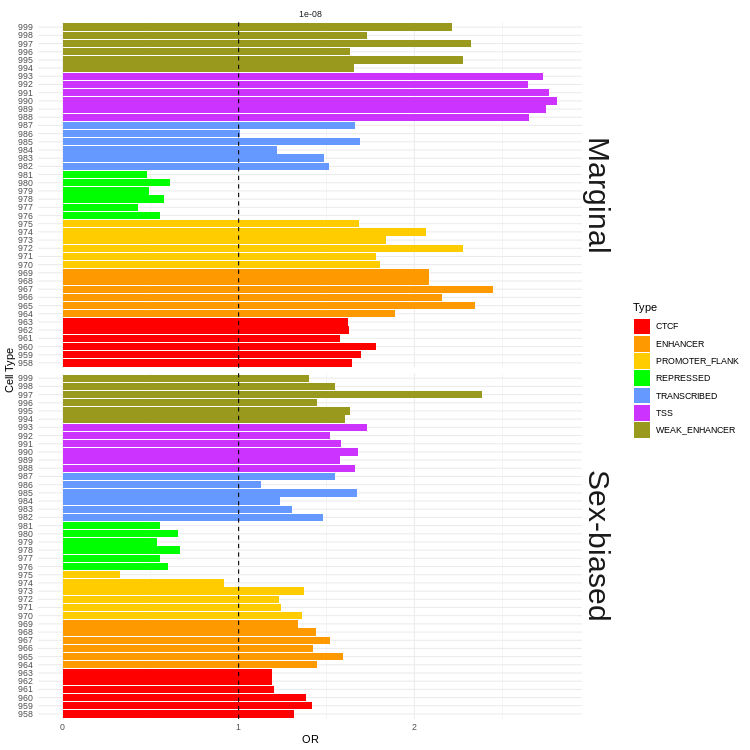

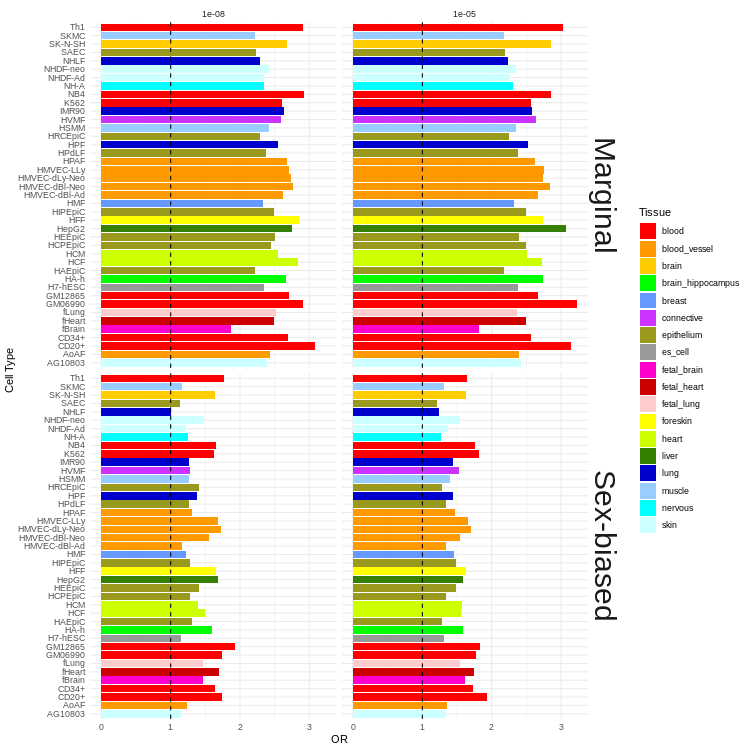

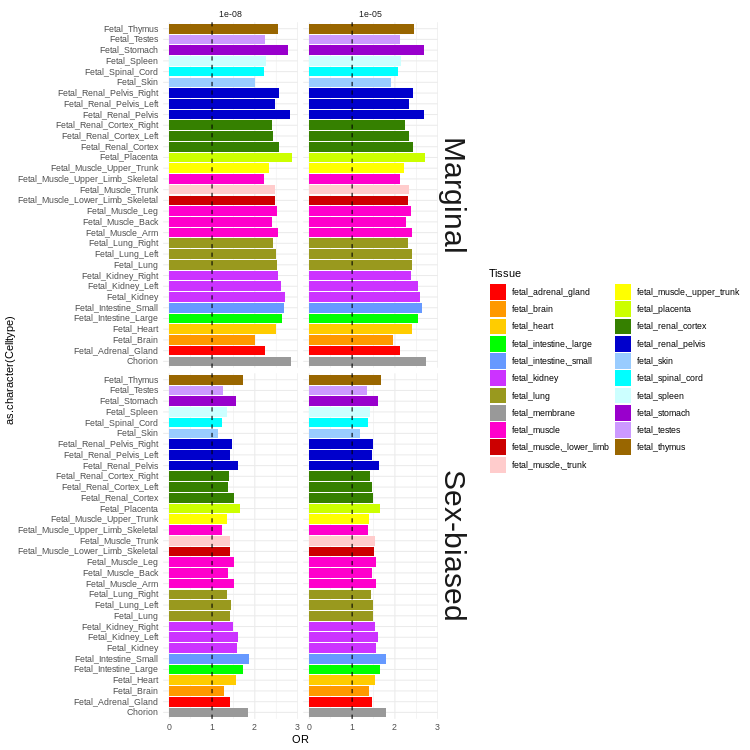

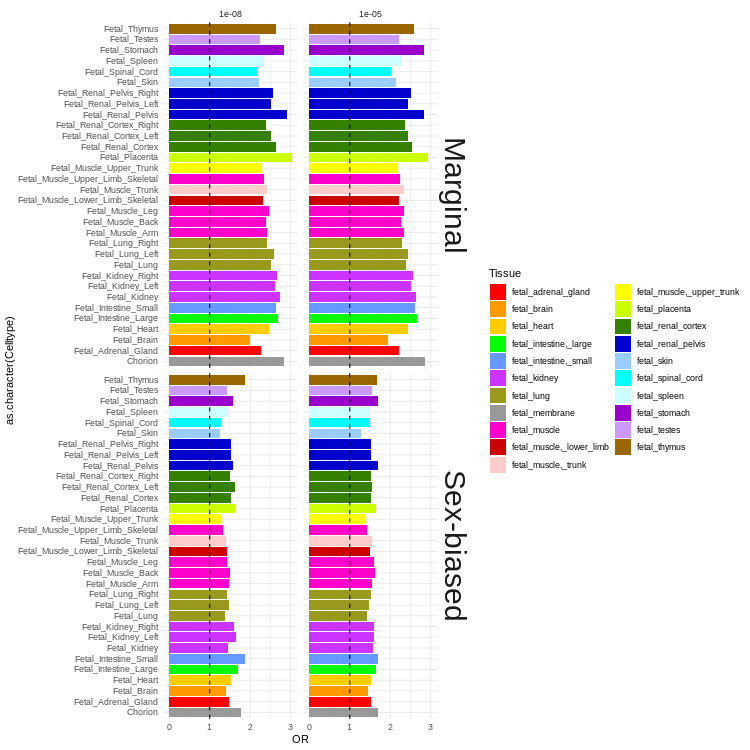

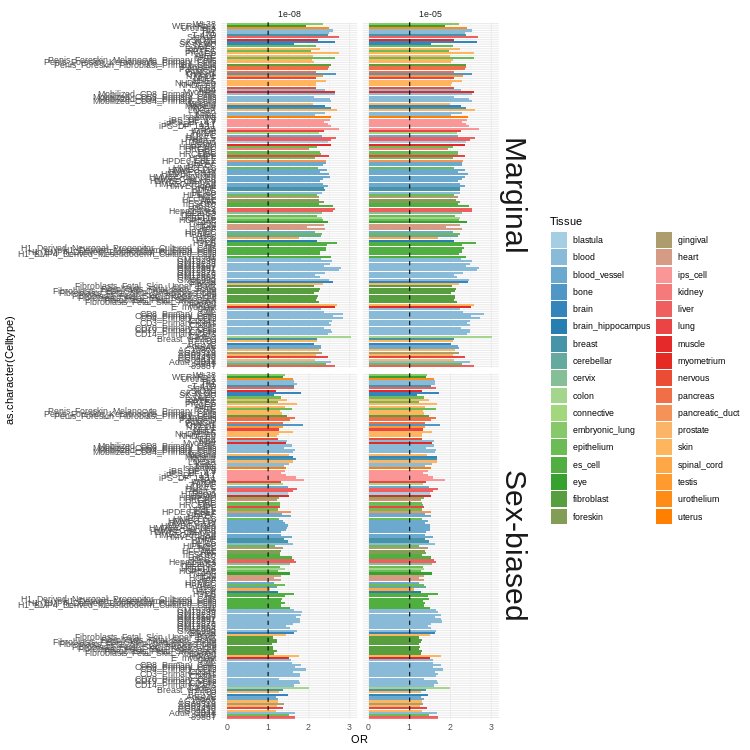

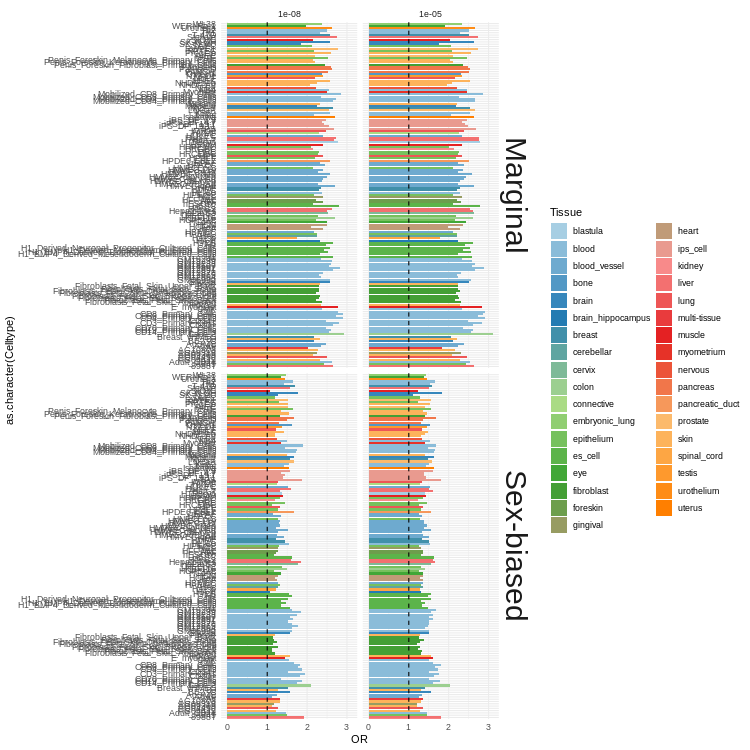

In [7]:
%%R -w 750 -h 750
garfield_marginal <- fread("../../1kg_ld_data/output/mqtl_delahaye/garfield.test.mqtl_delahaye.out")
garfield_sex <- fread("../../1kg_ld_data/output/mqtl_sex_delahaye/garfield.test.mqtl_sex_delahaye.out")
garfield_sex$Model = "Sex-biased"
garfield_marginal$Model = "Marginal"
garfield <- rbindlist(list(garfield_marginal, garfield_sex))[Category == "Chromatin_States" & PThresh == 1e-8] 
print(head(garfield_marginal))
p <- ggplot(garfield, aes(as.character(ID),OR,fill=Type)) +
    geom_bar(position = "identity", stat="identity") +
    geom_hline(linetype="dashed", yintercept=1) +
    
    facet_grid(Model~PThresh) + 
    labs(x="Cell Type")+
    scale_fill_ucscgb() + 
    coord_flip() + 
    theme_minimal() +
    theme(strip.text.y = element_text(size=30))
print(p)

garfield <- rbindlist(list(garfield_marginal, garfield_sex))[Category == "Footprints" ] 
p <- ggplot(garfield, aes(as.character(Celltype),OR,fill=Tissue)) +
    geom_bar(position = "identity", stat="identity") +
    geom_hline(linetype="dashed", yintercept=1) +
    facet_grid(Model~PThresh) + 
    labs(x="Cell Type")+
    scale_fill_ucscgb() + 
    coord_flip() + 
    theme_minimal() +
    theme(strip.text.y = element_text(size=30))
print(p)
garfield <- rbindlist(list(garfield_marginal, garfield_sex))[Category == "Hotspots"& grepl("fetal",Tissue)] 
p <- ggplot(garfield, aes(as.character(Celltype),OR,fill=Tissue)) +
    geom_bar(position = "identity", stat="identity") +
    geom_hline(linetype="dashed", yintercept=1) +
    facet_grid(Model~PThresh) + 
    scale_fill_ucscgb() + 
    coord_flip() + 
    theme_minimal() +
    theme(strip.text.y = element_text(size=30))
print(p)
garfield <- rbindlist(list(garfield_marginal, garfield_sex))[Category == "Peaks" & grepl("fetal",Tissue)] 
p <- ggplot(garfield, aes(as.character(Celltype),OR,fill=Tissue)) +
    geom_bar(position = "identity", stat="identity") +
    geom_hline(linetype="dashed", yintercept=1) +
    facet_grid(Model~PThresh) + 
    scale_fill_ucscgb() + 
    coord_flip() + 
    theme_minimal() +
    theme(strip.text.y = element_text(size=30))
print(p)


library(RColorBrewer)
# Define the number of colors you want

garfield <- rbindlist(list(garfield_marginal, garfield_sex))[Category == "Hotspots"& !grepl("fetal",Tissue)]
nb.cols <- length(unique(garfield$Tissue))
mycolors <- colorRampPalette(brewer.pal(8, "Paired"))(nb.cols)
p <- ggplot(garfield, aes(as.character(Celltype),OR,fill=Tissue)) +
    geom_bar(position = "identity", stat="identity") +
    geom_hline(linetype="dashed", yintercept=1) +
    facet_grid(Model~PThresh) + 
    scale_fill_manual(values = mycolors) +
    coord_flip() + 
    theme_minimal() +
    theme(strip.text.y = element_text(size=30))
print(p)
garfield <- rbindlist(list(garfield_marginal, garfield_sex))[Category == "Peaks" & !grepl("fetal",Tissue)] 
nb.cols <- length(unique(garfield$Tissue))
mycolors <- colorRampPalette(brewer.pal(8, "Paired"))(nb.cols)
p <- ggplot(garfield, aes(as.character(Celltype),OR,fill=Tissue)) +
    geom_bar(position = "identity", stat="identity") +
    geom_hline(linetype="dashed", yintercept=1) +
    facet_grid(Model~PThresh) + 
    scale_fill_manual(values = mycolors) +
    coord_flip() + 
    theme_minimal() +
    theme(strip.text.y = element_text(size=30))
print(p)


In [28]:
sbmqtl_genotypes.head()

,SNP,8366,8367,8368,8369,8370,8372,8374,8394,8396,...,TB8890,TB8891,TB8892,TB8899,TB8900,TB8901,TB8902,TB8903,TB8904,TB8905
110,rs61768207,2.000,1.015,2.000,1.147,2.000,1.989,2.000,2.000,2.000,...,1.017,1.941,1.999,1.019,2.000,2.000,1.991,0.625,2.000,2.000
777,rs28536514,2.000,1.000,2.000,1.000,2.000,2.000,2.000,2.000,2.000,...,2.000,2.000,2.000,2.000,2.000,2.000,1.999,1.000,2.000,2.000
1923,rs1539636,0.066,0.019,1.009,1.012,0.018,0.023,0.032,0.003,0.010,...,0.003,0.065,0.070,0.043,0.018,0.040,0.063,1.001,1.017,0.036
2711,rs11260579,2.000,2.000,0.022,1.997,2.000,1.002,2.000,1.946,2.000,...,2.000,2.000,2.000,2.000,2.000,1.001,2.000,1.008,1.015,1.999
2812,rs1536168,0.999,0.009,0.025,0.010,0.023,0.017,0.025,0.087,0.006,...,1.999,0.952,0.001,1.002,0.005,1.006,0.992,0.012,0.011,0.012


In [35]:
meta_info = metadata.set_index('id').transpose()
meta_info.groupby('Sex').agg(['mean','std'])['Gestational.Age.at.Delivery']
meta_info.groupby('Sex').count() / len(meta_info)

id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,batch,Gestational.Age.at.Delivery,V3,V4,V5,V6,V7
Sex,,,,,,,,,,,,,,,,
0.0,0.458182,0.458182,0.458182,0.458182,0.458182,0.458182,0.458182,0.458182,0.458182,0.458182,0.458182,0.458182,0.458182,0.458182,0.458182,0.458182
1.0,0.541818,0.541818,0.541818,0.541818,0.541818,0.541818,0.541818,0.541818,0.541818,0.541818,0.541818,0.541818,0.541818,0.541818,0.541818,0.541818


In [20]:
meta_info.head()

id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,batch,Gestational.Age.at.Delivery,V3,V4,V5,V6,V7,Sex
8366,-3.766228,-4.515446,11.972721,-13.362808,0.846419,-2.277688,3.066512,-4.518609,4.044228,0.0,273.0,-0.045568,0.001262,-0.097523,-0.000883,0.028139,0.0
8367,11.514503,-5.260580,-11.746535,-2.235483,4.616036,-1.201695,-0.344174,-5.691857,-1.736797,0.0,286.0,-0.051631,-0.066547,0.039453,0.024554,0.032294,1.0
8368,6.943321,2.998059,-4.533553,6.591855,4.471010,-2.321436,1.130970,-4.651071,3.168937,0.0,289.0,-0.049772,0.089263,0.067284,-0.004247,0.005266,1.0
8369,8.257881,2.804045,-10.641456,-4.545645,4.228029,-0.288869,1.333510,-5.270167,-2.059196,0.0,274.0,-0.050858,-0.066751,0.043047,0.027215,0.011792,1.0
8370,-6.792578,-8.864319,-6.427358,0.894547,6.846182,-5.117022,-6.338181,-4.739155,-0.455603,0.0,273.0,-0.037599,-0.037262,-0.007871,0.021923,0.019522,0.0


In [23]:
additional_meta = pd.read_csv("../../delahaye_QC/placenta_regulatory_landscape/RootStudyConsentSet_phs001717.PlacentalRegulation.v1.p1.c1.HMB-IRB-PUB-COL-MDS/PhenotypeFiles/phs001717.v1.pht008580.v1.p1.c1.Placental_Regulation_Subject_Phenotypes.HMB-IRB-PUB-COL-MDS.txt",comment = "#",sep='\t',index_col=False)
additional_meta.head()
additional_meta = additional_meta[additional_meta.SUBJECT_ID.isin(meta_info.index)]
additional_meta.groupby(['Gender', 'Preeclampsia Status']).count().groupby(level=0).apply(lambda x: x / x.sum())

dbGaP_Subject_ID  SUBJECT_ID  Birth weight  \
Gender Preeclampsia Status                                               
Female No                           0.968254    0.968254      0.968254   
       Yes                          0.031746    0.031746      0.031746   
Male   No                           0.966443    0.966443      0.966443   
       Yes                          0.033557    0.033557      0.033557   

                            Gestational Age at Delivery  Self declared race  \
Gender Preeclampsia Status                                                    
Female No                                      0.968254            0.968254   
       Yes                                     0.031746            0.031746   
Male   No                                      0.966443            0.966443   
       Yes                                     0.033557            0.033557   

                            Mode of delivery  Mode of labor  
Gender Preeclampsia Status                                   
Female No                           0.968254       0.968254  
       Yes                          0.031746       0.031746  
Male   No                           0.966443       0.966443  
       Yes                          0.033557       0.033557

In [43]:
len(delahaye_hits_sex[delahaye_hits_sex.SNP.isin(all_05)].gene.unique())
richs_delahaye= richs_sex.merge(delahaye_hits_sex[delahaye_hits_sex.SNP.isin(all_05)],on=["SNP","gene"]).compute()

In [44]:
len(richs_delahaye[richs_delahaye['FDR_x'] < 0.05].gene.unique())

66

In [45]:
%%R -i richs_delahaye
res <- qvalue::pi0est(richs_delahaye$`p-value_x`)
print(res)
print(1 - res$pi0)

$pi0
[1] 0.7233335

$pi0.lambda
 [1] 0.8141365 0.7868296 0.7608281 0.7636921 0.7398738 0.7458300 0.7403240
 [8] 0.7285666 0.7143391 0.7117125 0.7276015 0.7360336 0.7476587 0.7409101
[15] 0.6561214 0.6468867 0.6546585 0.7433483 0.8027796

$lambda
 [1] 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75
[16] 0.80 0.85 0.90 0.95

$pi0.smooth
 [1] 0.7908653 0.7810850 0.7714974 0.7623117 0.7536899 0.7457687 0.7386135
 [8] 0.7322740 0.7268043 0.7222243 0.7184690 0.7154134 0.7129940 0.7113149
[15] 0.7107309 0.7117273 0.7144529 0.7185607 0.7233335

[1] 0.2766665


In [46]:
print(f"Male Specific hits:{((aFC_df.SNP.isin(all_05))&((aFC_df['res_f'] >= threshold) & (aFC_df['res_m'] < threshold))).sum()}")
print(f"Female Specific hits:{((aFC_df.SNP.isin(all_05))&((aFC_df['res_f'] < threshold) & (aFC_df['res_m'] >= threshold))).sum()}")

Male Specific hits:8340
Female Specific hits:6132


In [47]:
print(f"All hits: {((aFC_df.SNP.isin(all_05)) & (aFC_df['FDR'] < 0.05)).sum()}")

All hits: 27963


In [50]:
print(delahaye_hits[delahaye_hits.SNP.isin(all_05)]) #Delahaye hits that are also in the sex-specific set

                 SNP        gene      beta      t-stat        p-value  \
239        rs9405044  cg03570263  0.410603  158.337670  1.976879e-257   
240        rs3910312  cg03570263  0.410603  158.337670  1.976879e-257   
241        rs9295829  cg03570263  0.410603  158.337670  1.976879e-257   
243       rs12200084  cg03570263  0.410661  158.306186  2.079059e-257   
244        rs9393987  cg03570263  0.410665  158.295710  2.114221e-257   
...              ...         ...       ...         ...            ...   
8712165    rs7503233  cg07073561  0.113915    3.252692   1.296810e-03   
8712166   rs66826982  cg07073561  0.113915    3.252692   1.296810e-03   
8712210   rs56975420  cg13173260 -0.017827   -3.252684   1.296842e-03   
8712302  rs367863202  cg21114334  0.038575    3.252672   1.296899e-03   
8712357     rs884978  cg01343703  0.009997    3.252664   1.296933e-03   

                   FDR  
239      2.739018e-251  
240      2.739018e-251  
241      2.739018e-251  
243      2.861826e-251 

In [65]:
genotypes.iloc[:,1:].sum(axis=1) / (2*(genotypes.shape[1]- 1))

19       0.997593
50       0.980073
72       0.980413
84       0.980078
90       0.979976
           ...   
78694    0.304929
78716    0.992295
78817    0.937575
78828    0.998815
78835    0.528004
Length: 237215, dtype: float64